# Figure - Covariance Comparison

May 2, 2022

The goal here is to generate plots for Figure 2 of the paper. The metric we want to use here is the *covariance* metric and not necessarily the *flow field* metric I've used previously.

Additionally, I want to sweep through different initializations and also different choices of $M$ and $W^{bmi1}$

* Metric plots averaged over initializations for biased RFLO, REINFORCE, and biased BPTT

* Metric plots for different choices of M (RFLO and BPTT)

* Metric plots for different choices of $W^{bmi0}$ and $W^{bmi1}$


This notebook combines code from `experiments/TCM-2022-4-5/fig2-gradient-2022-4-3.ipynb` and `experiments/Analytics-2022-4-20/New-Covariance-Metric-2022-4-28.ipynb`

In [1]:
folder = 'fig2-2022-5-4/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [63]:
def paper_format(fig,ax,xlabels=None,ylabels=None,labelsize=12,ticksize=10,linewidth=2,ylim=[0,1],figsize=(2.5,2.5)):
    
    """ Format Figure for Paper 8.5 x 11 """
    
    ax.set_ylim(ylim)
    
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    
    ax.xaxis.label.set_size(labelsize)
    ax.yaxis.label.set_size(labelsize)
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.tick_params(axis='y', labelsize=ticksize)
    
    
    ax.set_title(ax.get_title(),fontsize=labelsize)
    
    """ for small figures """
    if xlabels:
        ax.xaxis.set_major_locator(FixedLocator(xlabels))
        ax.xaxis.set_major_formatter(FixedFormatter(xlabels))
    
    if ylabels:
        ax.yaxis.set_major_locator(FixedLocator(ylabels))
        ax.yaxis.set_major_formatter(FixedFormatter(ylabels))
    
    if ax.get_legend_handles_labels()[1] != []:
        ax.legend(prop={"size":labelsize})
    
    """ this sets globally """
#     params = {'legend.fontsize': fontsize,
#               'figure.figsize': figsize,
#              'axes.labelsize': fontsize,
#              'axes.titlesize': fontsize,
#              'xtick.labelsize': fontsize,
#              'ytick.labelsize': fontsize}
#     pylab.rcParams.update(params)
        
    plt.tight_layout()
    


    return fig,ax

### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Part 1 - RFLO across multiple seeds

21it [00:00, 204.16it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb81d62fb40>


2500it [00:06, 396.74it/s]
92it [00:00, 914.11it/s]

M norm: 1.06	 M angle: 0.61, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

500it [00:00, 1058.30it/s]
1500it [00:04, 345.17it/s]
500it [00:00, 1045.82it/s]


AR early fit 0.963, late fit 0.977


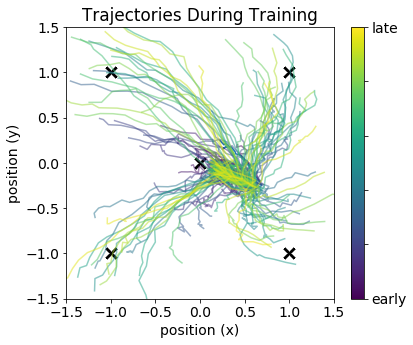

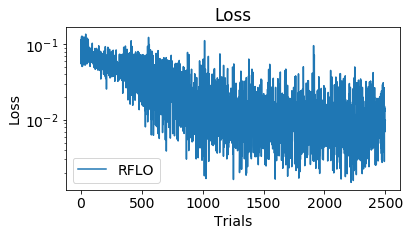

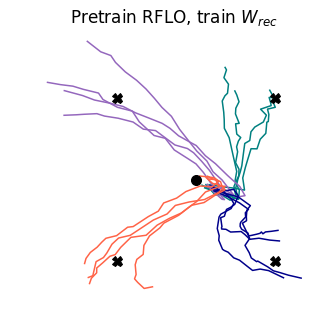

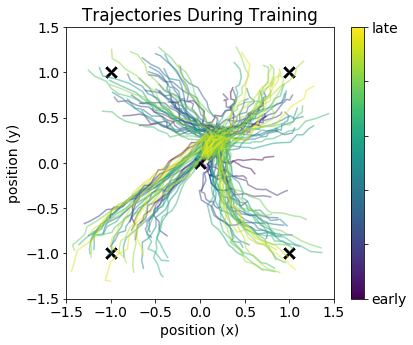

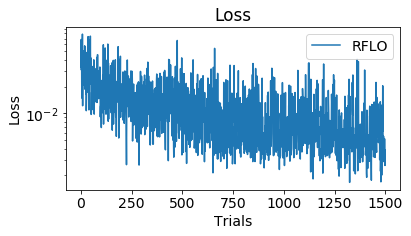

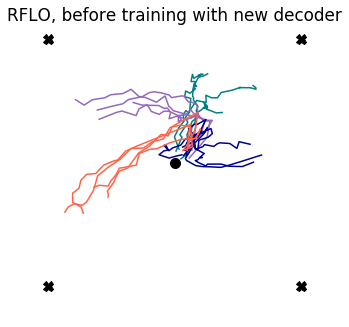

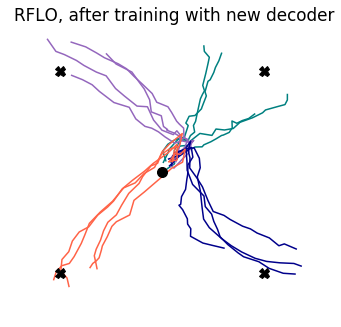

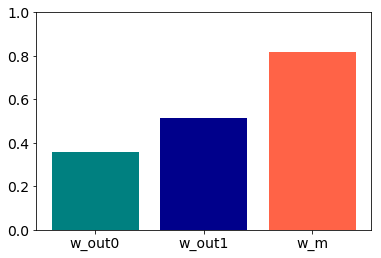

similarity DeltaC1 & DeltaC1_pred_w_out: 0.490
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.585
similarity DeltaC1 & DeltaC1_pred_w_m: 0.944


>> CTRL DeltaC1 & CTRL_h1_pre: 0.376
>> CTRL DeltaC1 & CTRL_h1_post: 0.853
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.463
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.401
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.720




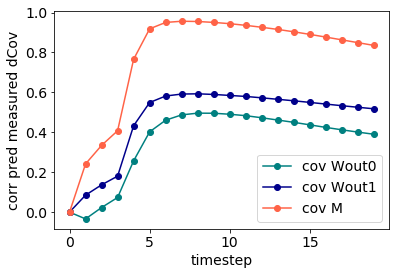

84it [00:00, 832.11it/s]

M norm: 1.10	 M angle: 0.60, 0 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.29

500it [00:00, 1027.97it/s]
1500it [00:04, 357.82it/s]
500it [00:00, 1116.64it/s]


AR early fit 0.963, late fit 0.978


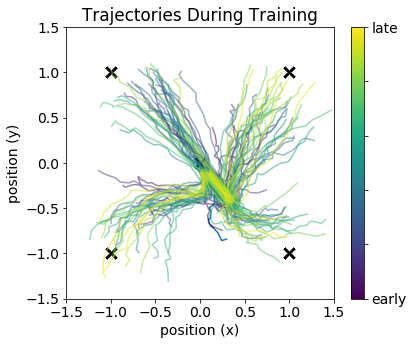

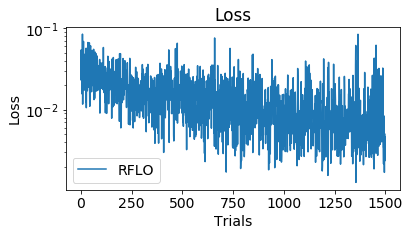

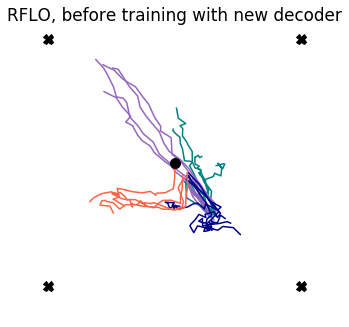

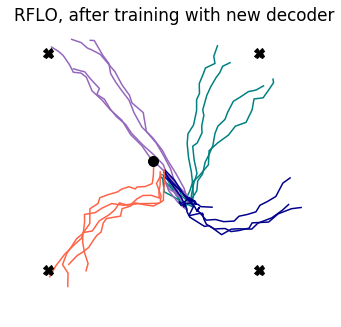

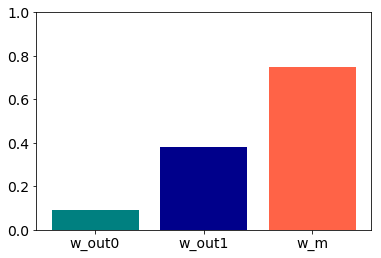

similarity DeltaC1 & DeltaC1_pred_w_out: 0.125
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.421
similarity DeltaC1 & DeltaC1_pred_w_m: 0.914


>> CTRL DeltaC1 & CTRL_h1_pre: 0.124
>> CTRL DeltaC1 & CTRL_h1_post: 0.835
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.086
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.302
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.606




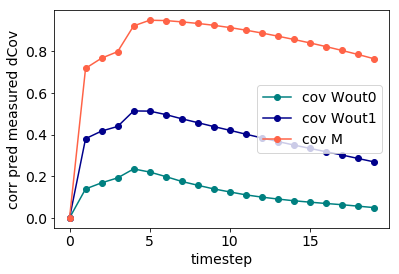

94it [00:00, 933.54it/s]

M norm: 1.09	 M angle: 0.60, 4 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.31

500it [00:00, 1065.75it/s]
1500it [00:04, 364.68it/s]
500it [00:00, 1055.02it/s]


AR early fit 0.963, late fit 0.973


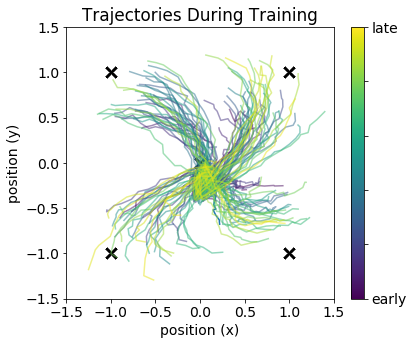

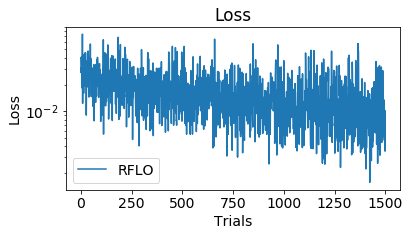

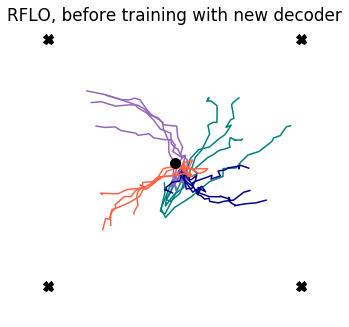

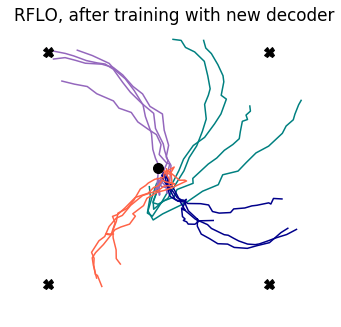

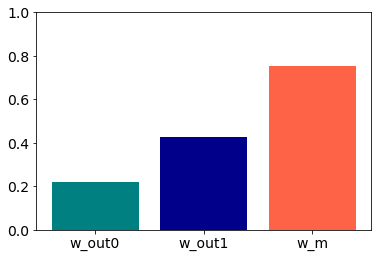

similarity DeltaC1 & DeltaC1_pred_w_out: 0.108
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.426
similarity DeltaC1 & DeltaC1_pred_w_m: 0.912


>> CTRL DeltaC1 & CTRL_h1_pre: -0.088
>> CTRL DeltaC1 & CTRL_h1_post: 0.665
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.167
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.369
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.546




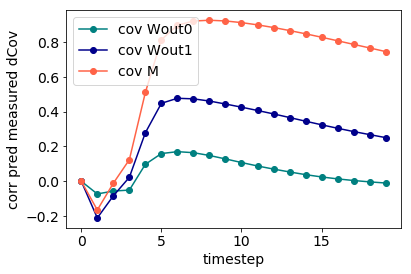

51it [00:00, 505.76it/s]

M norm: 1.07	 M angle: 0.60, 49 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.07	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.63	 w_out vs. w_m angle: 0.36

500it [00:00, 893.91it/s]
1500it [00:05, 271.98it/s]
500it [00:00, 634.98it/s]


AR early fit 0.963, late fit 0.976


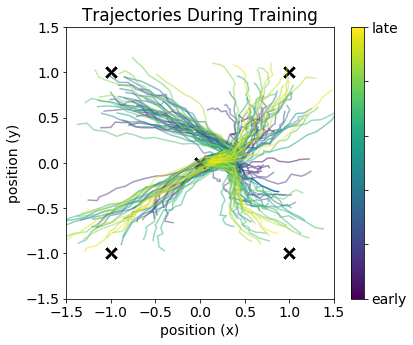

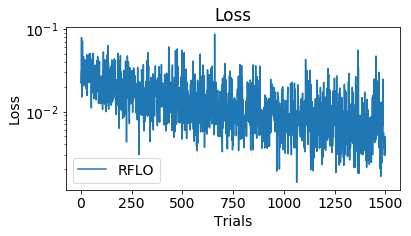

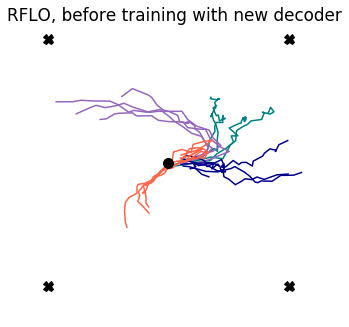

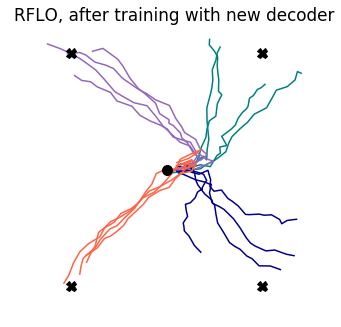

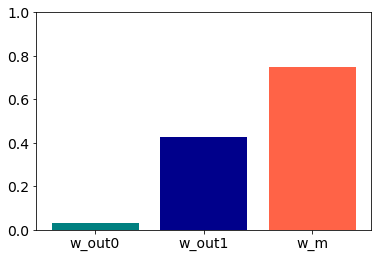

similarity DeltaC1 & DeltaC1_pred_w_out: 0.032
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.459
similarity DeltaC1 & DeltaC1_pred_w_m: 0.895


>> CTRL DeltaC1 & CTRL_h1_pre: 0.084
>> CTRL DeltaC1 & CTRL_h1_post: 0.760
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.014
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.368
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.620




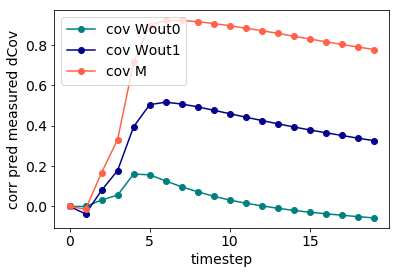

65it [00:00, 647.84it/s]

M norm: 1.08	 M angle: 0.61, 19 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.59	 w_out vs. w_m angle: 0.40

500it [00:00, 926.47it/s]
1500it [00:04, 331.06it/s]
500it [00:00, 863.65it/s]


AR early fit 0.963, late fit 0.977


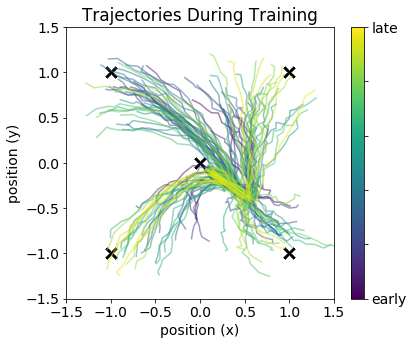

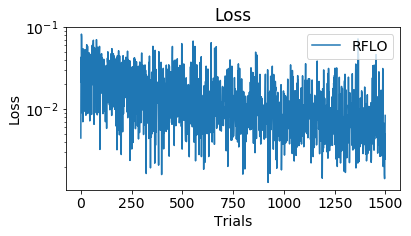

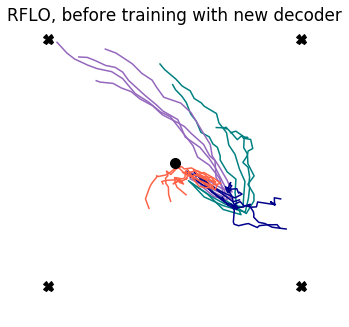

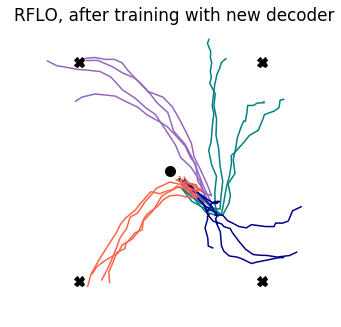

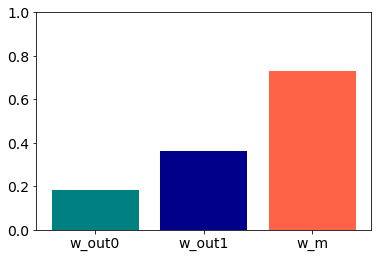

similarity DeltaC1 & DeltaC1_pred_w_out: 0.228
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.467
similarity DeltaC1 & DeltaC1_pred_w_m: 0.896


>> CTRL DeltaC1 & CTRL_h1_pre: 0.156
>> CTRL DeltaC1 & CTRL_h1_post: 0.809
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.224
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.292
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.629




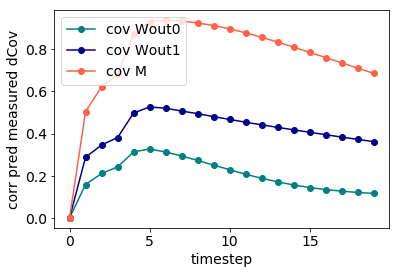

71it [00:00, 708.54it/s]

M norm: 1.10	 M angle: 0.61, 38 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.42

500it [00:00, 952.87it/s]
1500it [00:04, 350.28it/s]
500it [00:00, 1067.25it/s]


AR early fit 0.963, late fit 0.977


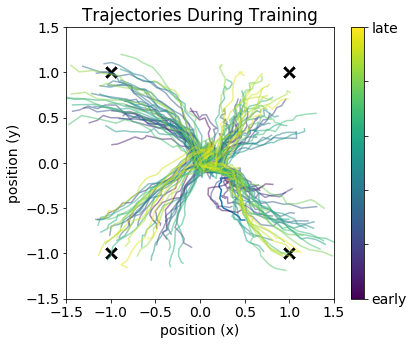

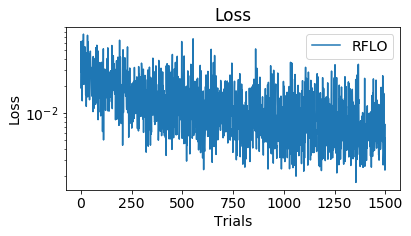

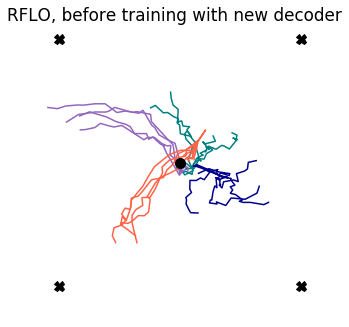

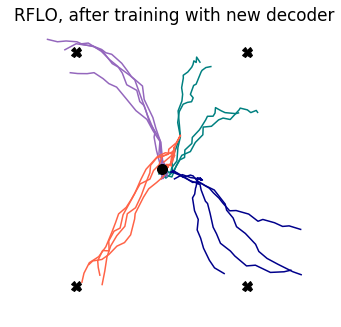

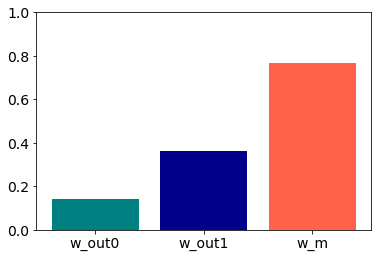

similarity DeltaC1 & DeltaC1_pred_w_out: 0.174
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.399
similarity DeltaC1 & DeltaC1_pred_w_m: 0.924


>> CTRL DeltaC1 & CTRL_h1_pre: 0.148
>> CTRL DeltaC1 & CTRL_h1_post: 0.824
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.163
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.296
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.638




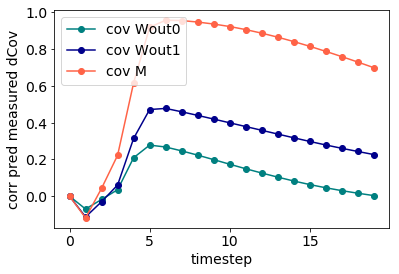

In [6]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,12,54,72,81]
overlaps = [0.6]
n_changes = [50]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
        """ Calculate Covariance """
        """ Activity During """
        covariance1 = np.zeros(task1.trial_duration)
        covariance2 = np.zeros(task1.trial_duration)
        covariance3 = np.zeros(task1.trial_duration)
        
        for t_ind in range(1,task1.trial_duration):
            """ Covariance Before """
            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

            C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

            """ Covariance After """
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point
            
            """ Change in Covariance (Measured)"""
            DeltaC1 = C1_post - C1_pre

            h1_train = sim1_train.session_probes['h']
            err1_train = sim1_train.session_probes['err']

            dW1_w_out = flow_field_predicted(net0.w_out,err1_train,h1_train)
            dW1_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_out1 = flow_field_predicted(net1.w_out,err1_train,h1_train)
            dW1_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
            dW1_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_out1 = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out1@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_pre[:,t_ind-1,:].T))
            
            """ Change in Covariance (Predicted) """
            DeltaC1_pred_w_out = C1_pred_w_out - C1_pre
            DeltaC1_pred_w_out1 = C1_pred_w_out1 - C1_pre
            DeltaC1_pred_w_m = C1_pred_w_m - C1_pre

            covariance1[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]
            covariance2[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]
            covariance3[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]
            


            if t_ind == 10:
                print('similarity DeltaC1 & DeltaC1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]))
                print('\n')

            CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
            CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
            CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_out1_h1_post = np.cov(dW1_w_out1@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

            if t_ind == 10:
                print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out1_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

                print('\n')
                
        covariance1_list.append(covariance1)
        covariance2_list.append(covariance2)
        covariance3_list.append(covariance3)
        
        fig,ax = plt.subplots(1,1)
        plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
        plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
        plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
        plt.legend()
        plt.xlabel('timestep')
        plt.ylabel('corr pred measured dCov')
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)
    stats['covariance1'].append(covariance1_list)
    stats['covariance2'].append(covariance2_list)
    stats['covariance3'].append(covariance3_list)


In [72]:
#stats_rflo = stats
#stats = stats_rflo

### Combine Covariance results

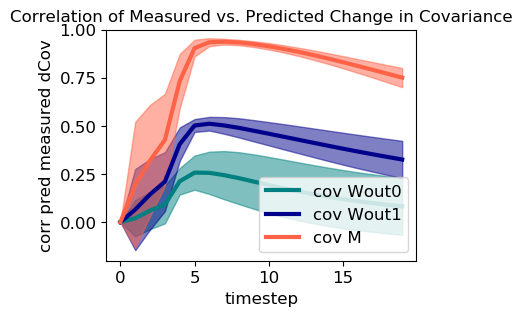

In [78]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

cov1 = np.mean(np.asarray(stats['covariance1']),axis=0).squeeze()
cov1_std = np.std(np.asarray(stats['covariance1']),axis=0).squeeze()
plt.plot(cov1,label='cov Wout0',color='teal',linewidth=3)
plt.fill_between(np.arange(cov1.shape[0]),cov1-cov1_std,cov1+cov1_std,alpha=0.5,color='teal')

cov2 = np.mean(np.asarray(stats['covariance2']),axis=0).squeeze()
cov2_std = np.std(np.asarray(stats['covariance2']),axis=0).squeeze()
plt.plot(cov2,label='cov Wout1',color='darkblue',linewidth=3)
plt.fill_between(np.arange(cov2.shape[0]),cov2-cov2_std,cov2+cov2_std,alpha=0.5,color='darkblue')

cov3 = np.mean(np.asarray(stats['covariance3']),axis=0).squeeze()
cov3_std = np.std(np.asarray(stats['covariance3']),axis=0).squeeze()
plt.plot(cov3,label='cov M',color='tomato',linewidth=3)
plt.fill_between(np.arange(cov3.shape[0]),cov3-cov3_std,cov3+cov3_std,alpha=0.5,color='tomato')

plt.legend(loc=4)
plt.ylim(top=1)
plt.xlabel('timestep')
plt.ylabel('corr pred measured dCov')
plt.title('Correlation of Measured vs. Predicted Change in Covariance')
plt.show()

Not too bad! It seems that the values start looking different _after_ the input signal stops

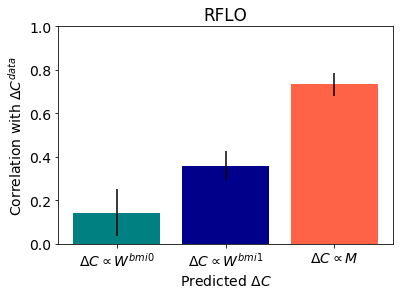

In [8]:
""" use covariance calculation to plot summary """
paper = False
save = False

fig,ax=plt.subplots(1,1)

""" take mean and std """
mn1 = np.mean(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
mn2 = np.mean(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
mn3 = np.mean(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)
std1 = np.std(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
std2 = np.std(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
std3 = np.std(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta C \propto W^{bmi0}$',r'$\Delta C \propto W^{bmi1}$',r'$\Delta C \propto M$'],color=['teal','darkblue','tomato'])

plt.title('RFLO')
plt.ylabel('Correlation with '+r'$\Delta C^{data}$')
plt.xlabel('Predicted '+r'$\Delta C$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],fontsize=12,linewidth=2,ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:

    fig.savefig('rflo-cov-correlation.pdf')

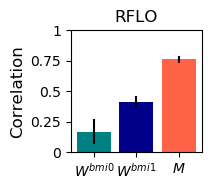

In [80]:
paper = True
save  = True

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

fig,ax = plt.subplots(1,1)

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$'],color=['teal','darkblue','tomato'])

plt.title('RFLO')
plt.ylabel('Correlation') #with '+r'$\Delta F^{data}$
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,1],figsize=(2,2.25))

plt.show()

if save:
    fig.savefig(folder+'rflo-dF-correlation.pdf')

# Part 2 - REINFORCE

18it [00:00, 177.49it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb81d62f990>


2500it [00:07, 330.91it/s]
60it [00:00, 591.42it/s]

M norm: 1.06	 M angle: 0.61, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

1000it [00:01, 670.20it/s]
15000it [00:43, 341.50it/s]
1000it [00:01, 715.40it/s]


AR early fit 0.964, late fit 0.980


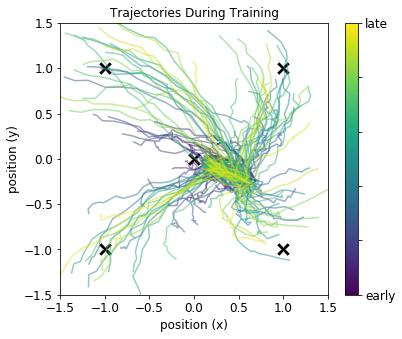

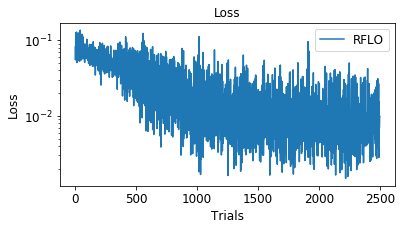

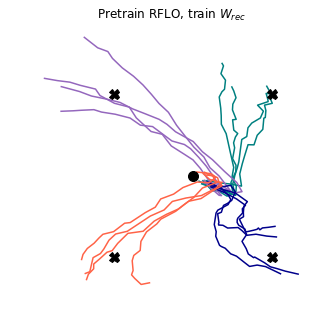

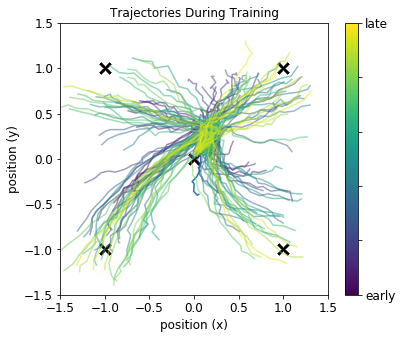

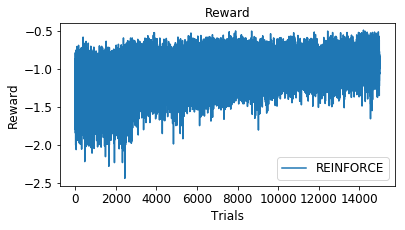

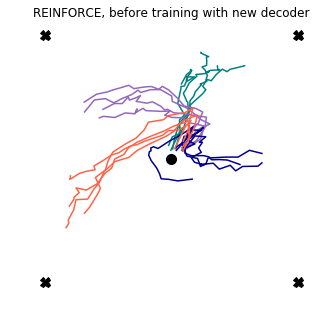

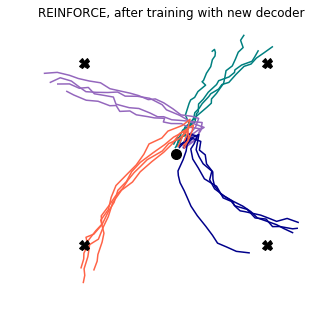

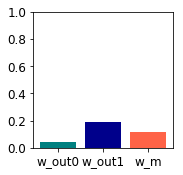

similarity DeltaC2 & DeltaC2_pred_w_out: 0.434
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.612
similarity DeltaC2 & DeltaC2_pred_w_m: 0.402


>> CTRL DeltaC2 & CTRL_h2_pre: 0.636
>> CTRL DeltaC2 & CTRL_h2_post: 0.909
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.427
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.415
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.216




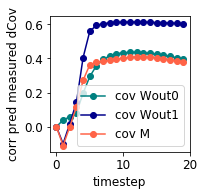

62it [00:00, 619.91it/s]

M norm: 1.10	 M angle: 0.60, 0 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.29

1000it [00:00, 1009.31it/s]
15000it [00:43, 343.85it/s]
1000it [00:00, 1005.79it/s]


AR early fit 0.964, late fit 0.982


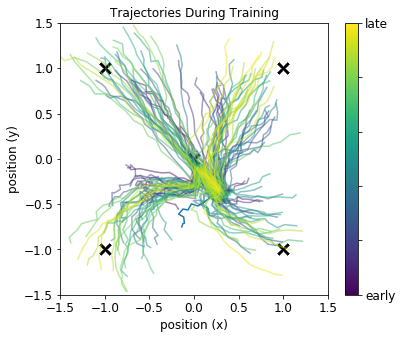

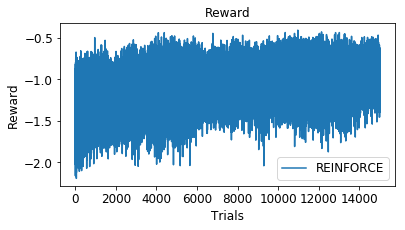

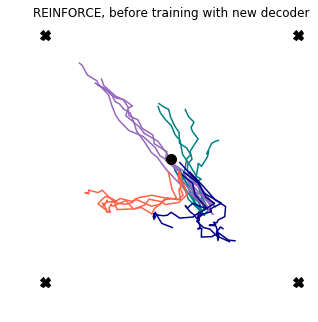

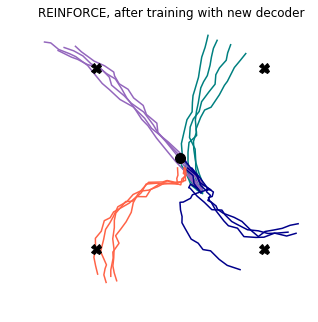

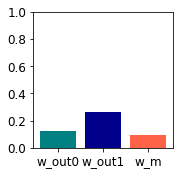

similarity DeltaC2 & DeltaC2_pred_w_out: 0.572
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.683
similarity DeltaC2 & DeltaC2_pred_w_m: 0.315


>> CTRL DeltaC2 & CTRL_h2_pre: 0.709
>> CTRL DeltaC2 & CTRL_h2_post: 0.946
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.569
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.436
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.105




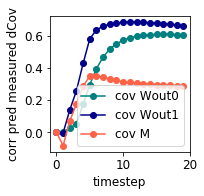

63it [00:00, 627.17it/s]

M norm: 1.09	 M angle: 0.60, 4 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.31

1000it [00:01, 896.77it/s]
15000it [00:32, 457.54it/s]
1000it [00:01, 998.38it/s]


AR early fit 0.964, late fit 0.981


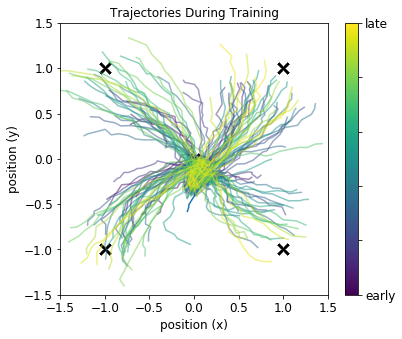

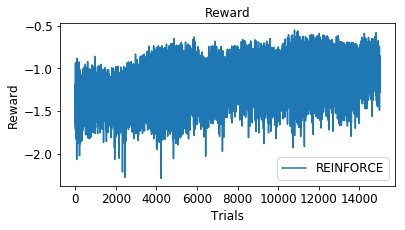

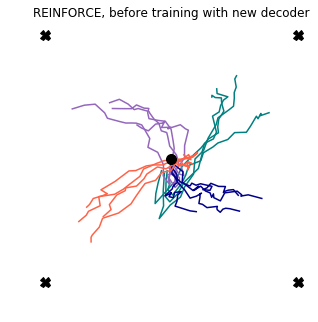

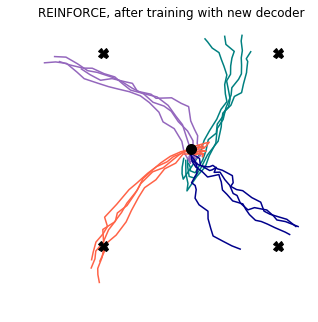

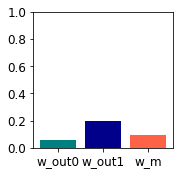

similarity DeltaC2 & DeltaC2_pred_w_out: 0.492
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.563
similarity DeltaC2 & DeltaC2_pred_w_m: 0.305


>> CTRL DeltaC2 & CTRL_h2_pre: 0.588
>> CTRL DeltaC2 & CTRL_h2_post: 0.900
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.486
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.328
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.063




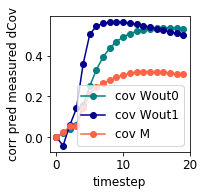

69it [00:00, 689.88it/s]

M norm: 1.07	 M angle: 0.60, 49 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.07	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.63	 w_out vs. w_m angle: 0.36

1000it [00:01, 968.84it/s]
15000it [00:42, 354.64it/s]
1000it [00:01, 873.37it/s]


AR early fit 0.964, late fit 0.981


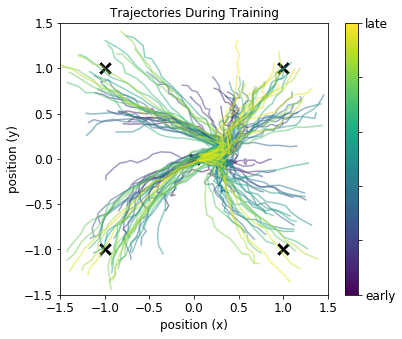

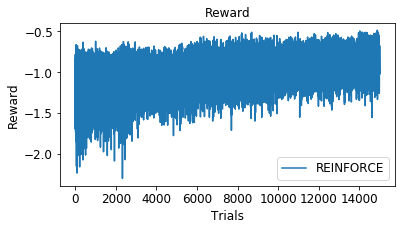

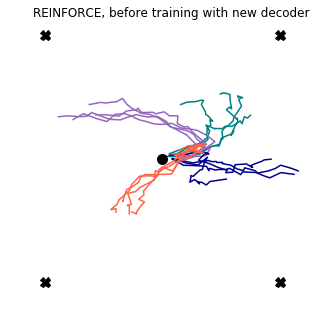

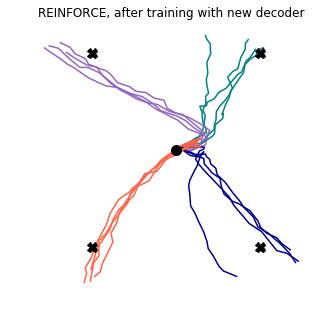

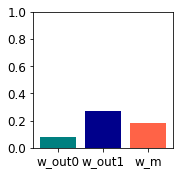

similarity DeltaC2 & DeltaC2_pred_w_out: 0.384
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.690
similarity DeltaC2 & DeltaC2_pred_w_m: 0.351


>> CTRL DeltaC2 & CTRL_h2_pre: 0.620
>> CTRL DeltaC2 & CTRL_h2_post: 0.919
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.378
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.493
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.149




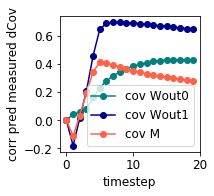

82it [00:00, 812.95it/s]

M norm: 1.08	 M angle: 0.61, 19 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.59	 w_out vs. w_m angle: 0.40

1000it [00:00, 1040.27it/s]
15000it [00:31, 473.92it/s]
1000it [00:00, 1075.53it/s]


AR early fit 0.964, late fit 0.981


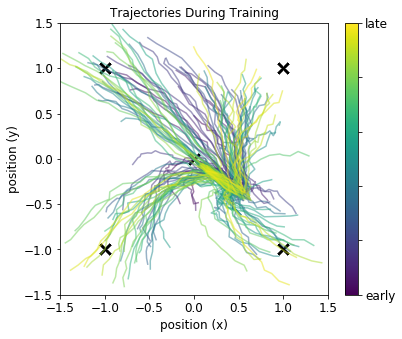

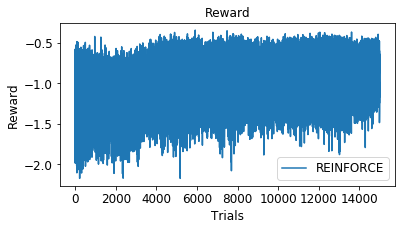

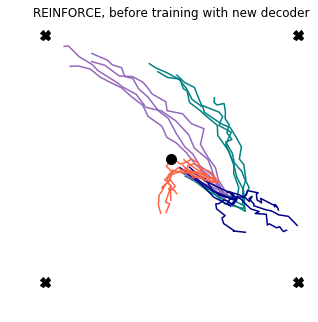

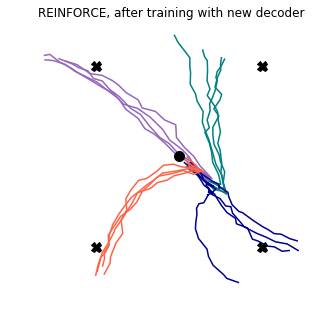

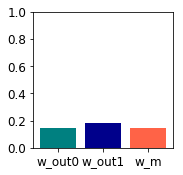

similarity DeltaC2 & DeltaC2_pred_w_out: 0.511
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.626
similarity DeltaC2 & DeltaC2_pred_w_m: 0.386


>> CTRL DeltaC2 & CTRL_h2_pre: 0.656
>> CTRL DeltaC2 & CTRL_h2_post: 0.929
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.511
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.368
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.145




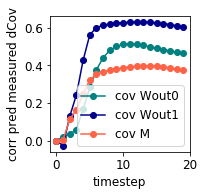

75it [00:00, 748.07it/s]

M norm: 1.10	 M angle: 0.61, 38 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.42

1000it [00:01, 949.73it/s]
15000it [00:35, 422.64it/s]
1000it [00:01, 992.36it/s]


AR early fit 0.964, late fit 0.982


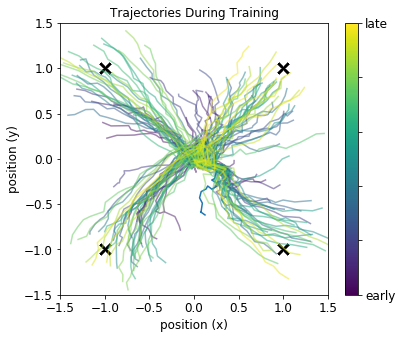

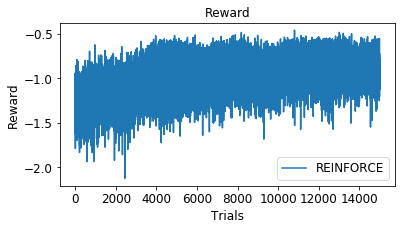

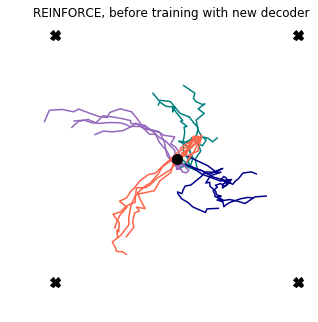

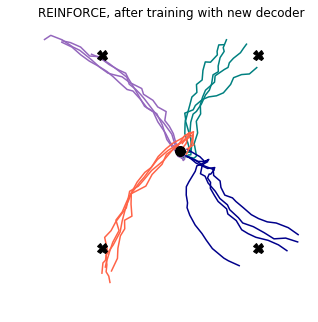

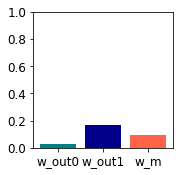

similarity DeltaC2 & DeltaC2_pred_w_out: 0.552
similarity DeltaC2 & DeltaC2_pred_w_out1: 0.631
similarity DeltaC2 & DeltaC2_pred_w_m: 0.314


>> CTRL DeltaC2 & CTRL_h2_pre: 0.730
>> CTRL DeltaC2 & CTRL_h2_post: 0.947
>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: 0.549
>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: 0.404
>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: 0.102




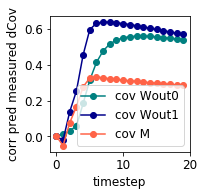

In [15]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,12,54,72,81]
overlaps = [0.6]
n_changes = [50]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=15000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
        
        """ Calculate Covariance """
        """ Activity During """
        covariance1 = np.zeros(task1.trial_duration)
        covariance2 = np.zeros(task1.trial_duration)
        covariance3 = np.zeros(task1.trial_duration)
        
        for t_ind in range(1,task1.trial_duration):
            """ Covariance Before """
            h2_pre = np.asarray(sim2_pre.session_probes['h']).squeeze()

            C2_pre = np.cov(h2_pre[:,t_ind,:].T) # neurons x trials at a single time point

            """ Covariance After """
            h2_post = np.asarray(sim2_post.session_probes['h']).squeeze()

            C2_post = np.cov(h2_post[:,t_ind,:].T) # neurons x trials at a single time point
            
            """ Change in Covariance """
            DeltaC2 = C2_post - C2_pre

            h2_train = sim2_train.session_probes['h']
            err2_train = sim2_train.session_probes['err']

            dW2_w_out = flow_field_predicted(net0.w_out,err2_train,h2_train)
            dW2_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW2_w_out1 = flow_field_predicted(net2.w_out,err1_train,h1_train)
            dW2_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW2_w_m = flow_field_predicted(w_m,err1_train,h1_train) # w_m defined above
            dW2_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

            h2_pre = np.asarray(sim2_pre.session_probes['h']).squeeze()
            h2_post = np.asarray(sim2_post.session_probes['h']).squeeze()

            C2_pred_w_out = np.cov(h2_pre[:,t_ind,:].T + dW2_w_out@(h2_post[:,t_ind-1,:].T))
            C2_pred_w_out1 = np.cov(h2_pre[:,t_ind,:].T + dW2_w_out1@(h2_post[:,t_ind-1,:].T))
            C2_pred_w_m = np.cov(h2_pre[:,t_ind,:].T + dW2_w_m@(h2_post[:,t_ind-1,:].T))
            
            DeltaC2_pred_w_out = C2_pred_w_out - C2_pre
            DeltaC2_pred_w_out1 = C2_pred_w_out1 - C2_pre
            DeltaC2_pred_w_m = C2_pred_w_m - C2_pre

            covariance1[t_ind] = np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_out.ravel())[0,1]
            covariance2[t_ind] = np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_out1.ravel())[0,1]
            covariance3[t_ind] = np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_m.ravel())[0,1]
            


            if t_ind == 10:
                print('similarity DeltaC2 & DeltaC2_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_out.ravel())[0,1]))
                print('similarity DeltaC2 & DeltaC2_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_out1.ravel())[0,1]))
                print('similarity DeltaC2 & DeltaC2_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),DeltaC2_pred_w_m.ravel())[0,1]))
                print('\n')

            CTRL_h2_pre = np.cov(h2_pre[:,t_ind,:].T)
            CTRL_h2_post = np.cov(h2_post[:,t_ind,:].T)
            CTRL_dW2_w_out_h2_post = np.cov(dW2_w_out@(h2_post[:,t_ind,:].T))
            CTRL_dW2_w_out1_h2_post = np.cov(dW2_w_out1@(h2_post[:,t_ind,:].T))
            CTRL_dW2_w_m_h2_post = np.cov(dW2_w_m@(h2_post[:,t_ind,:].T))

            if t_ind == 10:
                print('>> CTRL DeltaC2 & CTRL_h2_pre: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_h2_pre.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_out_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_out1_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_m_h2_post.ravel())[0,1]))

                print('\n')
                
        covariance1_list.append(covariance1)
        covariance2_list.append(covariance2)
        covariance3_list.append(covariance3)
        
        fig,ax = plt.subplots(1,1)
        plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
        plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
        plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
        plt.legend()
        plt.xlabel('timestep')
        plt.ylabel('corr pred measured dCov')
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)
    
    stats['covariance1'].append(covariance1_list)
    stats['covariance2'].append(covariance2_list)
    stats['covariance3'].append(covariance3_list)


In [69]:
stats_reinforce = stats

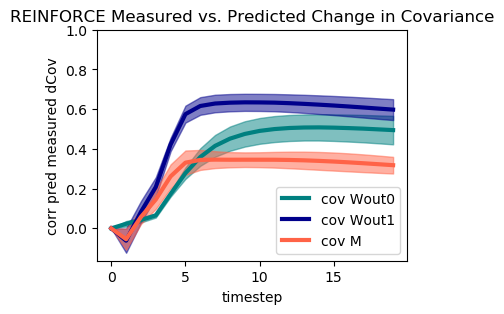

In [26]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

cov1 = np.mean(np.asarray(stats['covariance1']),axis=0).squeeze()
cov1_std = np.std(np.asarray(stats['covariance1']),axis=0).squeeze()
plt.plot(cov1,label='cov Wout0',color='teal',linewidth=3)
plt.fill_between(np.arange(cov1.shape[0]),cov1-cov1_std,cov1+cov1_std,alpha=0.5,color='teal')

cov2 = np.mean(np.asarray(stats['covariance2']),axis=0).squeeze()
cov2_std = np.std(np.asarray(stats['covariance2']),axis=0).squeeze()
plt.plot(cov2,label='cov Wout1',color='darkblue',linewidth=3)
plt.fill_between(np.arange(cov2.shape[0]),cov2-cov2_std,cov2+cov2_std,alpha=0.5,color='darkblue')

cov3 = np.mean(np.asarray(stats['covariance3']),axis=0).squeeze()
cov3_std = np.std(np.asarray(stats['covariance3']),axis=0).squeeze()
plt.plot(cov3,label='cov M',color='tomato',linewidth=3)
plt.fill_between(np.arange(cov3.shape[0]),cov3-cov3_std,cov3+cov3_std,alpha=0.5,color='tomato')

plt.legend(loc=4)
plt.ylim(top=1)
plt.xlabel('timestep')
plt.ylabel('corr pred measured dCov')
plt.title('REINFORCE Measured vs. Predicted Change in Covariance')
plt.show()

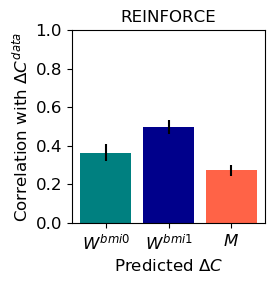

In [35]:
paper = False
save = False

""" use covariance calculation to plot summary """

""" take mean and std """
mn1 = np.mean(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
mn2 = np.mean(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
mn3 = np.mean(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)
std1 = np.std(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
std2 = np.std(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
std3 = np.std(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)

fig,ax = plt.subplots(1,1)
plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$'],color=['teal','darkblue','tomato'])

plt.title('REINFORCE')
plt.ylabel('Correlation with '+r'$\Delta C^{data}$')
plt.xlabel('Predicted '+r'$\Delta C$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],fontsize=12,linewidth=2,ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:
    fig.savefig(folder+'reinforce-xov-correlation.pdf')

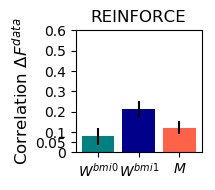

In [71]:
paper = True
save = True

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

fig,ax = plt.subplots(1,1)
plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$'],color=['teal','darkblue','tomato'])

plt.title('REINFORCE')
plt.ylabel('Correlation '+r'$\Delta F^{data}$')
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.05,0.1,0.2,0.3,0.40,0.5,0.6],ticksize=10,linewidth=2,ylim=[0,0.6],figsize=(2,2.25))

    

plt.show()

if save:
    fig.savefig(folder+'reinforce-dF-correlation.pdf')

# Part 3 - RFLO across choices of M

21it [00:00, 199.04it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb81ef49900>


2500it [00:06, 386.86it/s]
83it [00:00, 823.68it/s]

M norm: 1.20	 M angle: 0.26, 12 iterations
w_out1 norm: 1.73	 w_out vs. w_out1 angle: 0.25
w_m norm: 1.20	 w_out1 vs. w_m angle: 0.26
w_m norm: 1.83	 w_out vs. w_m angle: 0.08

500it [00:00, 1008.18it/s]
1500it [00:04, 353.83it/s]
500it [00:00, 1071.75it/s]


AR early fit 0.963, late fit 0.986


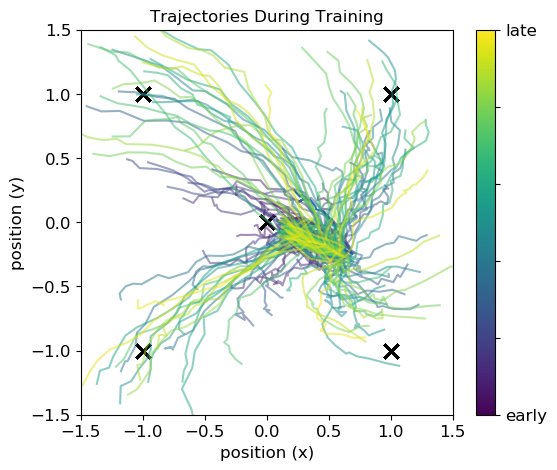

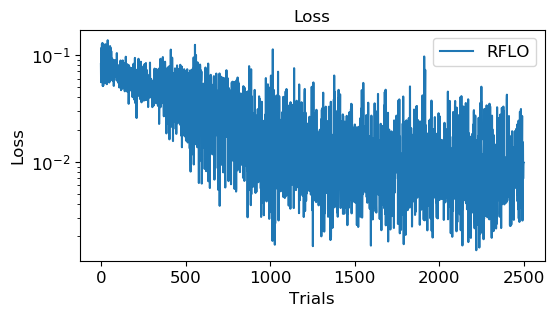

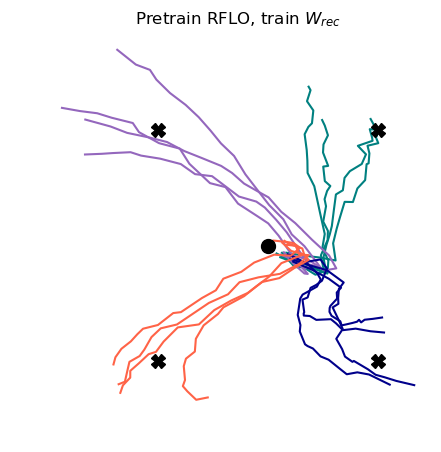

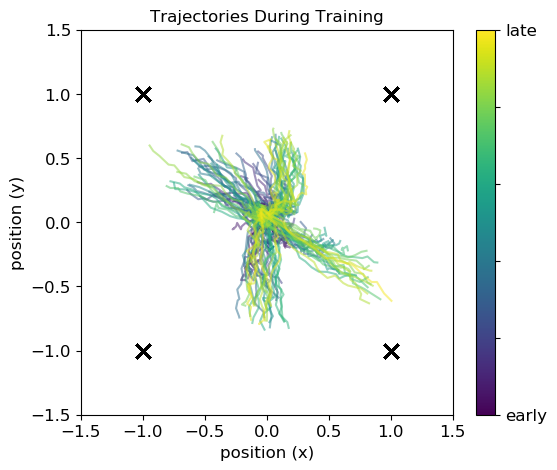

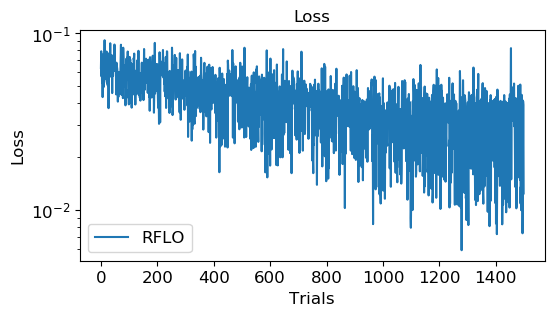

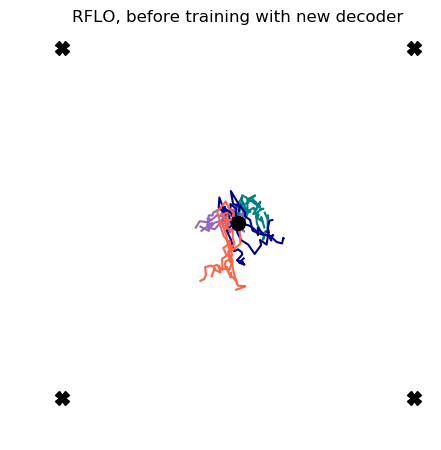

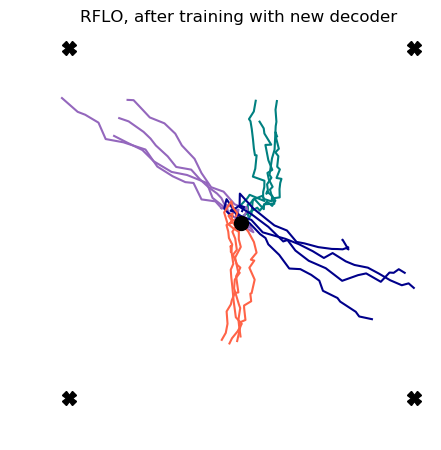

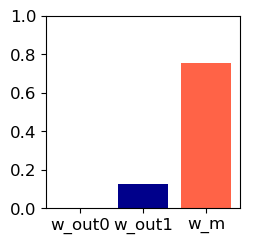

similarity DeltaC1 & DeltaC1_pred_w_out: -0.046
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.069
similarity DeltaC1 & DeltaC1_pred_w_m: 0.892


>> CTRL DeltaC1 & CTRL_h1_pre: -0.068
>> CTRL DeltaC1 & CTRL_h1_post: 0.944
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.023
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.049
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.723




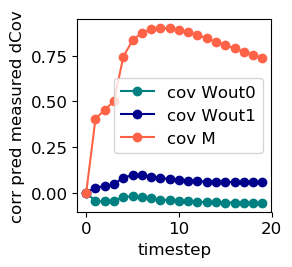

62it [00:00, 619.73it/s]

M norm: 1.21	 M angle: 0.49, 34 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.21	 w_out1 vs. w_m angle: 0.49
w_m norm: 1.85	 w_out vs. w_m angle: 0.11

500it [00:00, 970.41it/s]
1500it [00:04, 345.38it/s]
500it [00:00, 1071.56it/s]


AR early fit 0.963, late fit 0.976


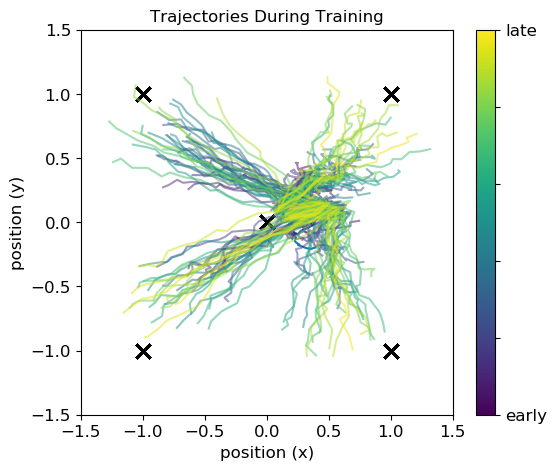

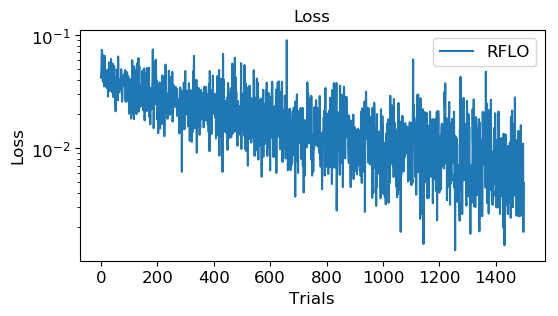

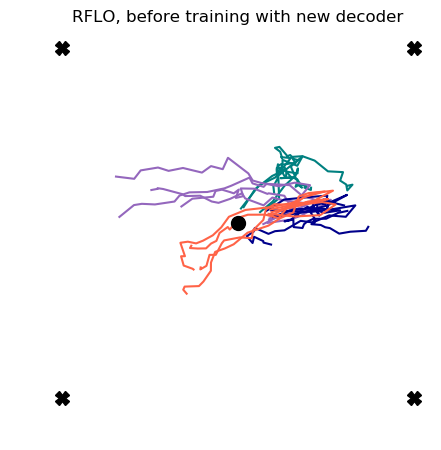

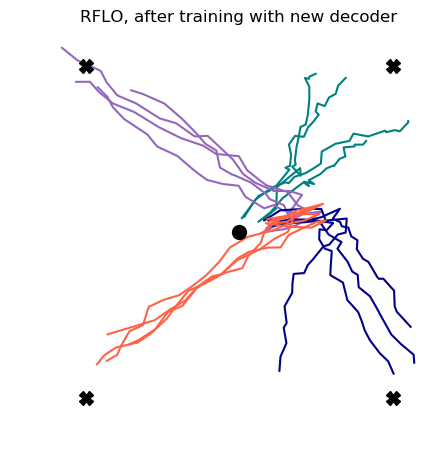

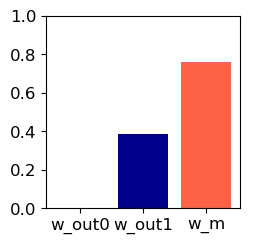

similarity DeltaC1 & DeltaC1_pred_w_out: -0.082
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.457
similarity DeltaC1 & DeltaC1_pred_w_m: 0.873


>> CTRL DeltaC1 & CTRL_h1_pre: -0.046
>> CTRL DeltaC1 & CTRL_h1_post: 0.740
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.082
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.371
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.446




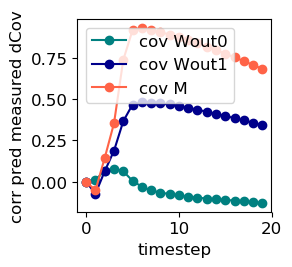

50it [00:00, 497.87it/s]

M norm: 0.94	 M angle: 0.75, 11 iterations
w_out1 norm: 1.10	 w_out vs. w_out1 angle: 0.76
w_m norm: 0.94	 w_out1 vs. w_m angle: 0.75
w_m norm: 1.38	 w_out vs. w_m angle: 0.58

500it [00:00, 896.04it/s]
1500it [00:05, 277.42it/s]
500it [00:00, 800.93it/s]


AR early fit 0.963, late fit 0.975


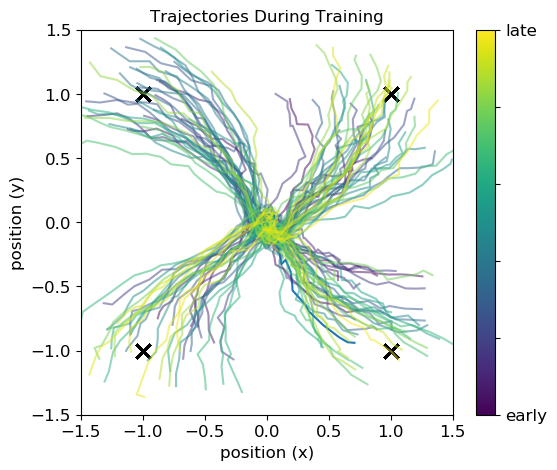

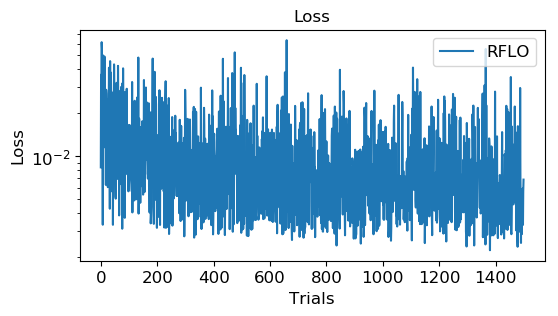

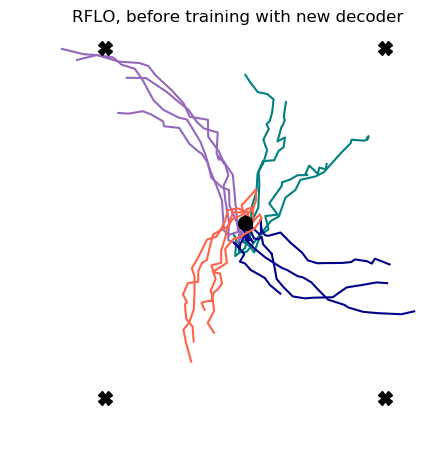

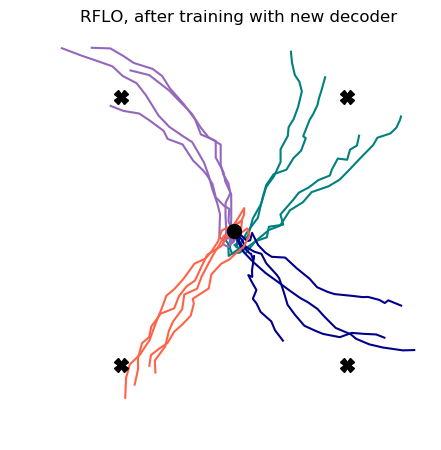

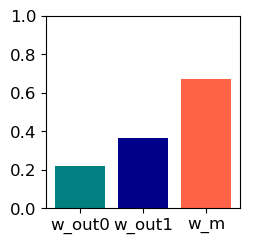

similarity DeltaC1 & DeltaC1_pred_w_out: 0.602
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.682
similarity DeltaC1 & DeltaC1_pred_w_m: 0.935


>> CTRL DeltaC1 & CTRL_h1_pre: 0.576
>> CTRL DeltaC1 & CTRL_h1_post: 0.855
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.534
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.452
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.644




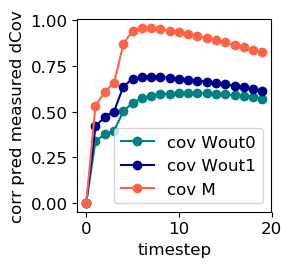

38it [00:00, 377.16it/s]

M norm: 0.67	 M angle: 0.90, 296 iterations
w_out1 norm: 0.76	 w_out vs. w_out1 angle: 0.89
w_m norm: 0.67	 w_out1 vs. w_m angle: 0.90
w_m norm: 0.95	 w_out vs. w_m angle: 0.82

500it [00:00, 881.36it/s]
1500it [00:04, 347.57it/s]
500it [00:00, 852.70it/s]


AR early fit 0.963, late fit 0.969


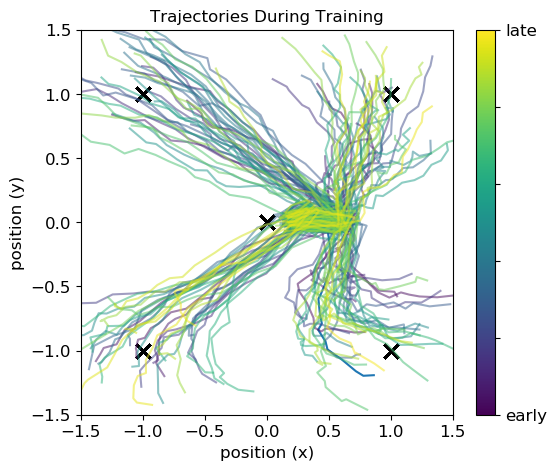

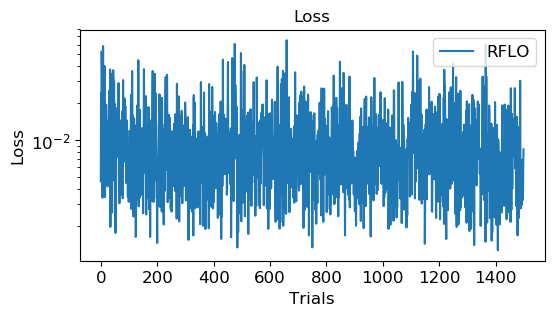

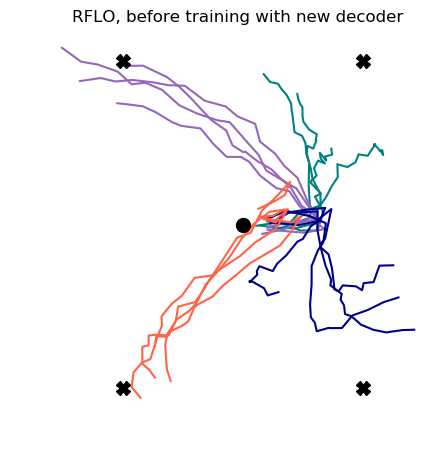

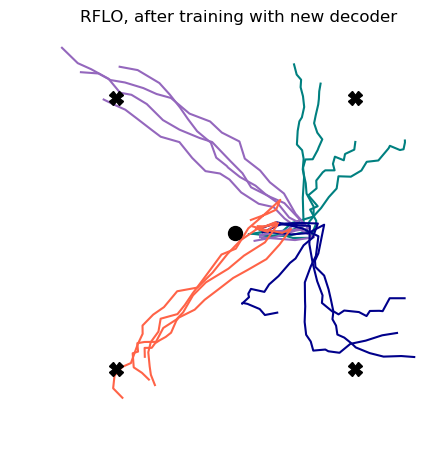

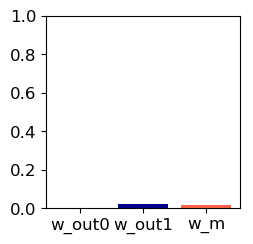

similarity DeltaC1 & DeltaC1_pred_w_out: 0.771
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.792
similarity DeltaC1 & DeltaC1_pred_w_m: 0.841


>> CTRL DeltaC1 & CTRL_h1_pre: 0.872
>> CTRL DeltaC1 & CTRL_h1_post: 0.928
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.601
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.586
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.622




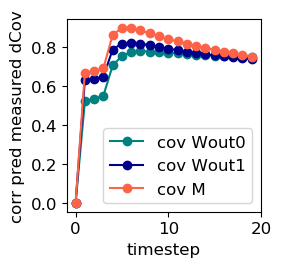

72it [00:00, 713.44it/s]

M norm: 1.19	 M angle: 0.25, 26 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.25
w_m norm: 1.19	 w_out1 vs. w_m angle: 0.25
w_m norm: 1.77	 w_out vs. w_m angle: 0.11

500it [00:00, 934.05it/s]
1500it [00:04, 314.90it/s]
500it [00:00, 1061.69it/s]


AR early fit 0.963, late fit 0.982


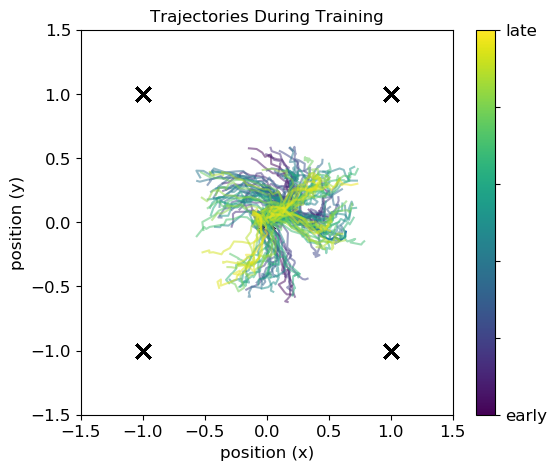

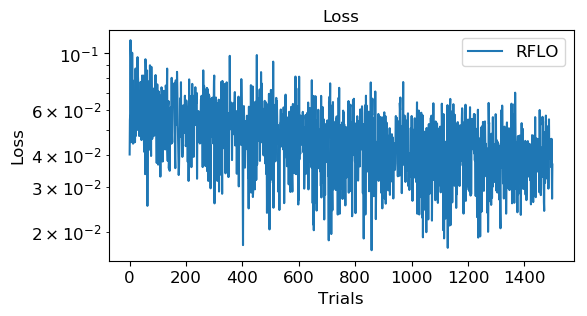

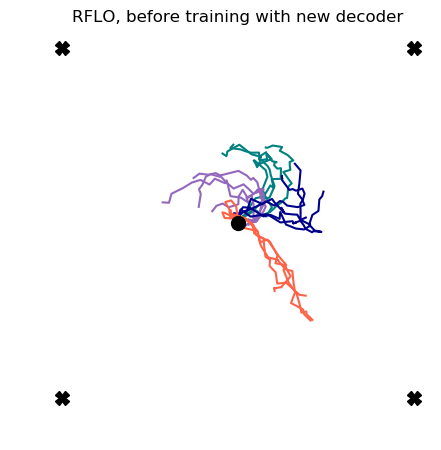

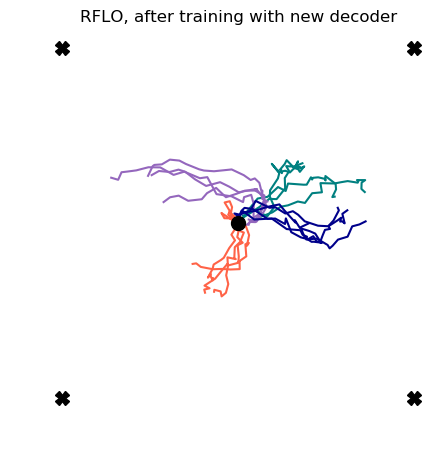

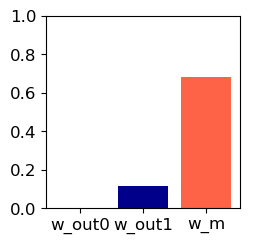

similarity DeltaC1 & DeltaC1_pred_w_out: -0.111
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.083
similarity DeltaC1 & DeltaC1_pred_w_m: 0.885


>> CTRL DeltaC1 & CTRL_h1_pre: -0.160
>> CTRL DeltaC1 & CTRL_h1_post: 0.849
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.119
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.050
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.632




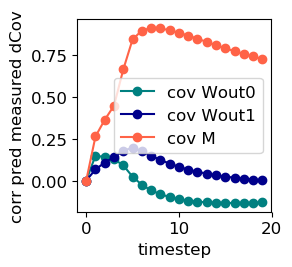

65it [00:00, 648.61it/s]

M norm: 1.19	 M angle: 0.50, 36 iterations
w_out1 norm: 1.51	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.19	 w_out1 vs. w_m angle: 0.50
w_m norm: 1.72	 w_out vs. w_m angle: 0.26

500it [00:00, 937.11it/s]
1500it [00:04, 343.30it/s]
500it [00:00, 904.90it/s]


AR early fit 0.963, late fit 0.975


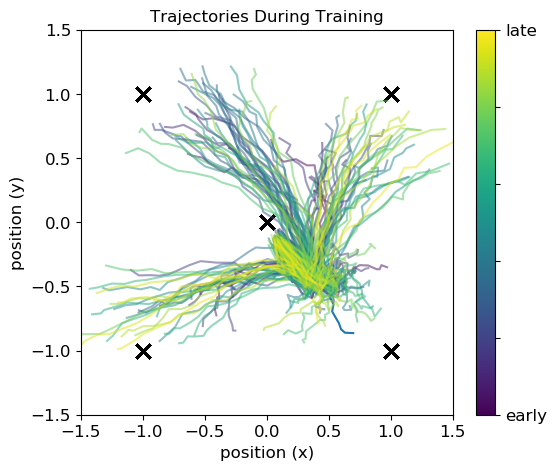

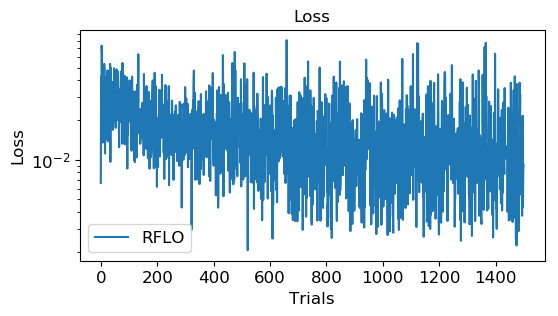

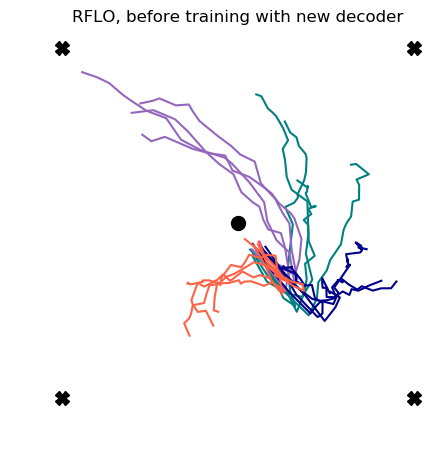

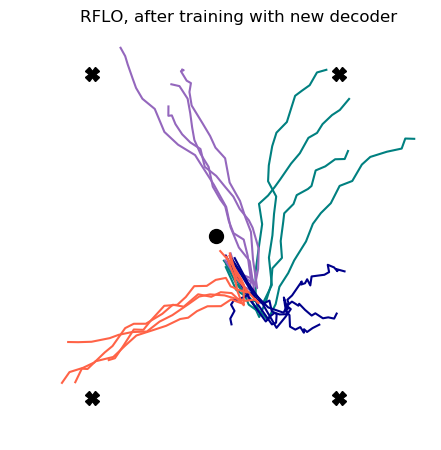

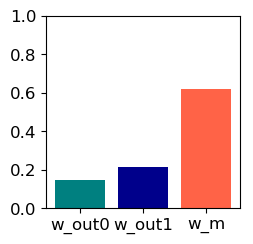

similarity DeltaC1 & DeltaC1_pred_w_out: 0.227
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.321
similarity DeltaC1 & DeltaC1_pred_w_m: 0.943


>> CTRL DeltaC1 & CTRL_h1_pre: 0.072
>> CTRL DeltaC1 & CTRL_h1_post: 0.780
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.231
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.210
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.573




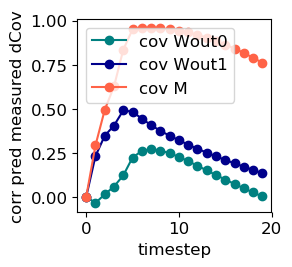

35it [00:00, 345.44it/s]

M norm: 0.91	 M angle: 0.74, 154 iterations
w_out1 norm: 1.10	 w_out vs. w_out1 angle: 0.75
w_m norm: 0.91	 w_out1 vs. w_m angle: 0.74
w_m norm: 1.47	 w_out vs. w_m angle: 0.50

500it [00:00, 872.23it/s]
1500it [00:04, 355.92it/s]
500it [00:00, 1099.13it/s]


AR early fit 0.963, late fit 0.974


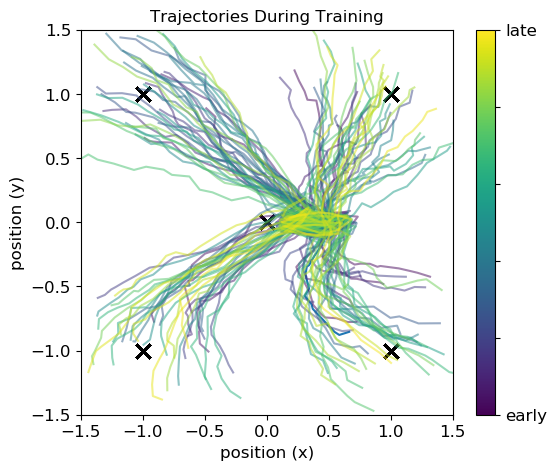

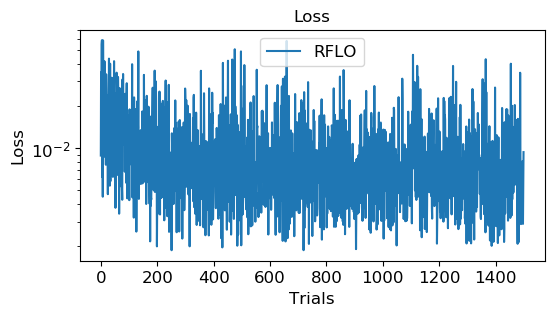

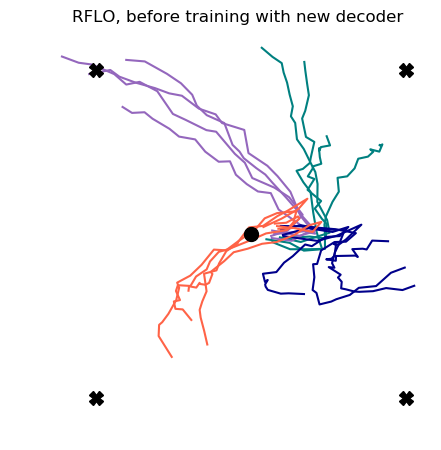

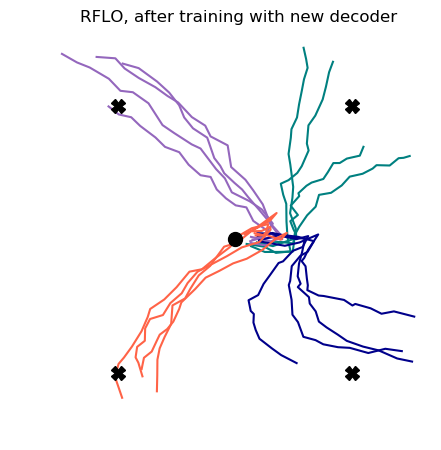

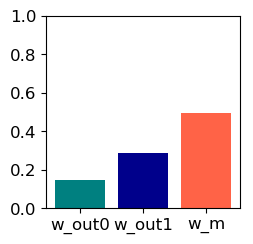

similarity DeltaC1 & DeltaC1_pred_w_out: 0.630
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.702
similarity DeltaC1 & DeltaC1_pred_w_m: 0.899


>> CTRL DeltaC1 & CTRL_h1_pre: 0.664
>> CTRL DeltaC1 & CTRL_h1_post: 0.864
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.547
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.504
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.546




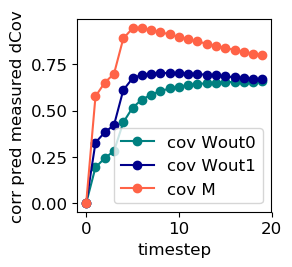

33it [00:00, 329.46it/s]

M norm: 0.68	 M angle: 0.90, 103 iterations
w_out1 norm: 0.75	 w_out vs. w_out1 angle: 0.90
w_m norm: 0.68	 w_out1 vs. w_m angle: 0.90
w_m norm: 0.98	 w_out vs. w_m angle: 0.81

500it [00:00, 881.97it/s]
1500it [00:04, 330.81it/s]
500it [00:00, 978.75it/s]


AR early fit 0.963, late fit 0.970


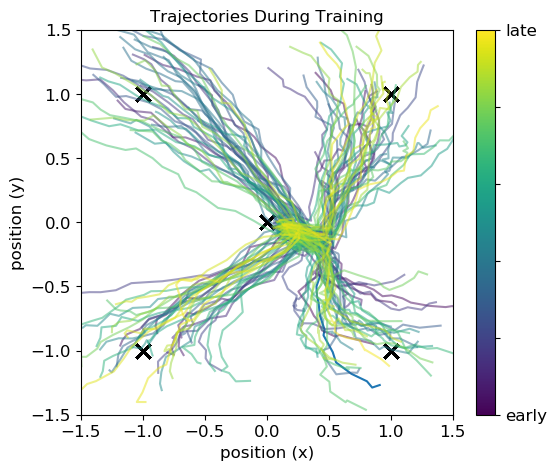

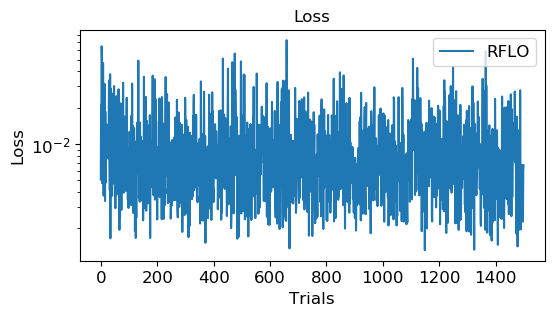

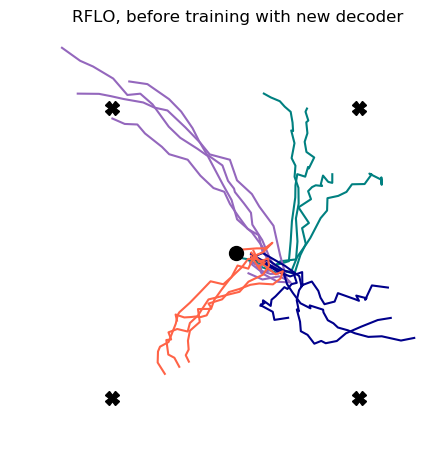

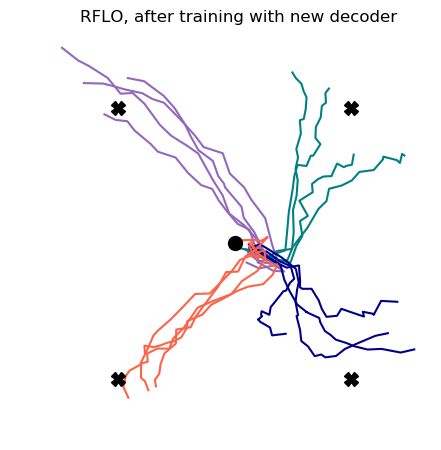

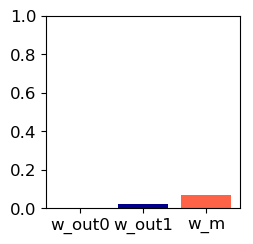

similarity DeltaC1 & DeltaC1_pred_w_out: 0.786
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.811
similarity DeltaC1 & DeltaC1_pred_w_m: 0.873


>> CTRL DeltaC1 & CTRL_h1_pre: 0.748
>> CTRL DeltaC1 & CTRL_h1_post: 0.865
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.712
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.675
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.652




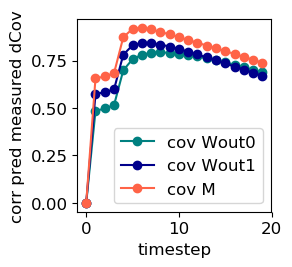

77it [00:00, 768.30it/s]

M norm: 1.25	 M angle: 0.25, 14 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.25
w_m norm: 1.25	 w_out1 vs. w_m angle: 0.25
w_m norm: 1.69	 w_out vs. w_m angle: 0.26

500it [00:00, 953.32it/s]
1500it [00:04, 324.29it/s]
500it [00:00, 885.74it/s]


AR early fit 0.963, late fit 0.988


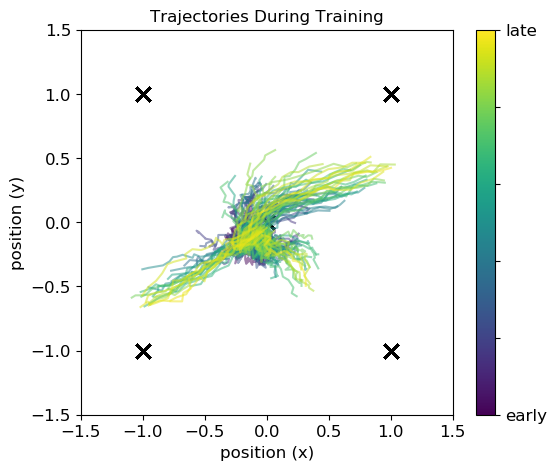

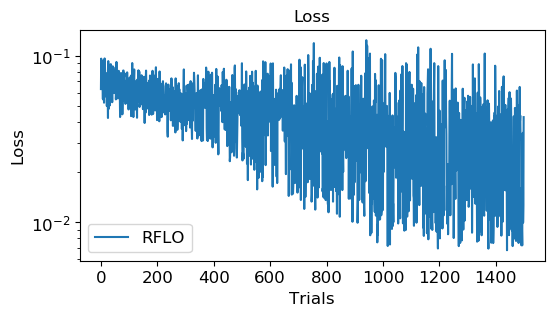

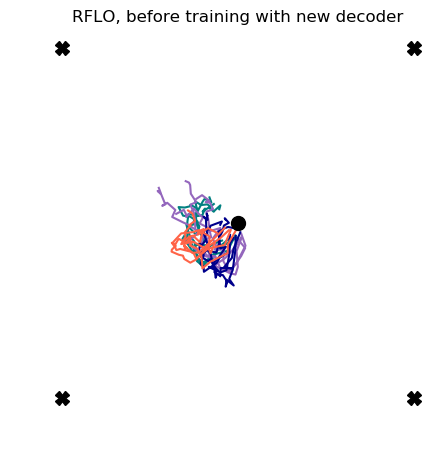

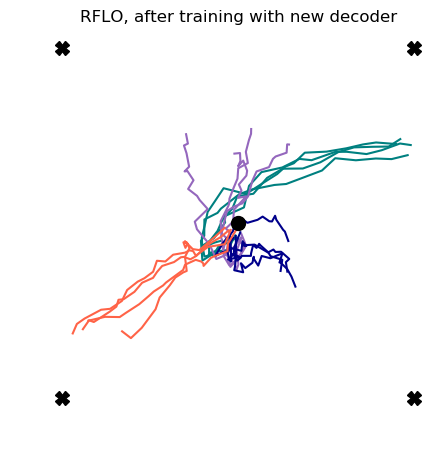

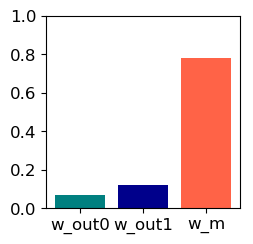

similarity DeltaC1 & DeltaC1_pred_w_out: 0.072
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.122
similarity DeltaC1 & DeltaC1_pred_w_m: 0.924


>> CTRL DeltaC1 & CTRL_h1_pre: 0.095
>> CTRL DeltaC1 & CTRL_h1_post: 0.966
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.037
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.036
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.821




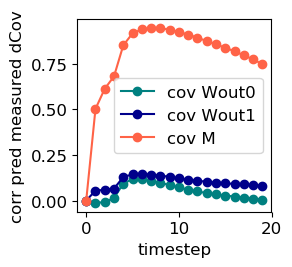

51it [00:00, 507.11it/s]

M norm: 1.17	 M angle: 0.50, 33 iterations
w_out1 norm: 1.49	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.50
w_m norm: 1.73	 w_out vs. w_m angle: 0.25

500it [00:00, 817.26it/s]
1500it [00:04, 305.04it/s]
500it [00:00, 952.47it/s]


AR early fit 0.963, late fit 0.977


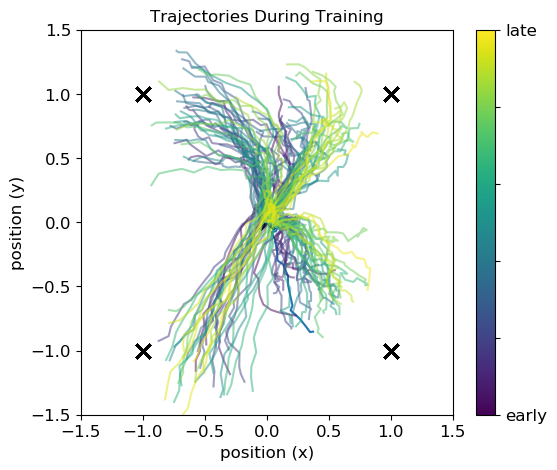

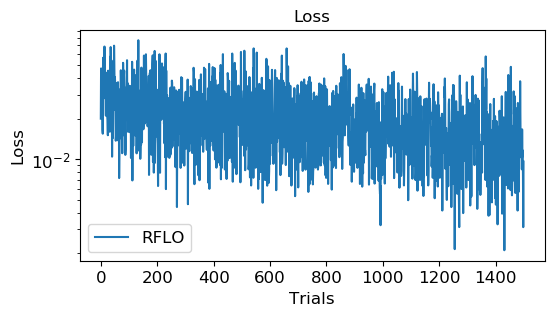

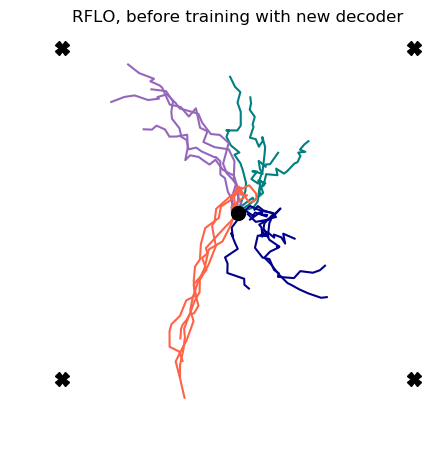

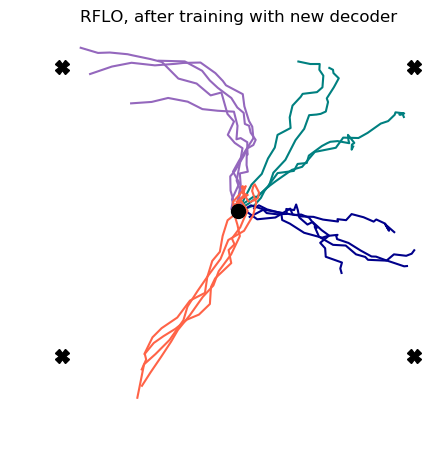

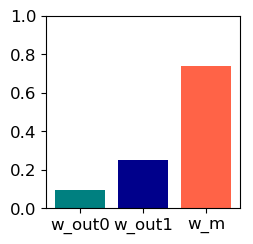

similarity DeltaC1 & DeltaC1_pred_w_out: -0.029
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.286
similarity DeltaC1 & DeltaC1_pred_w_m: 0.872


>> CTRL DeltaC1 & CTRL_h1_pre: -0.024
>> CTRL DeltaC1 & CTRL_h1_post: 0.709
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.032
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.186
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.617




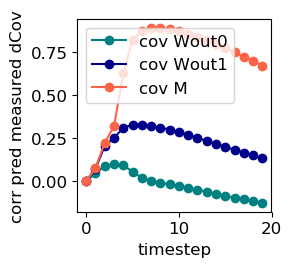

26it [00:00, 259.19it/s]

M norm: 0.86	 M angle: 0.75, 235 iterations
w_out1 norm: 1.09	 w_out vs. w_out1 angle: 0.75
w_m norm: 0.86	 w_out1 vs. w_m angle: 0.75
w_m norm: 1.39	 w_out vs. w_m angle: 0.56

500it [00:00, 779.28it/s]
1500it [00:04, 308.36it/s]
500it [00:00, 964.04it/s]


AR early fit 0.963, late fit 0.977


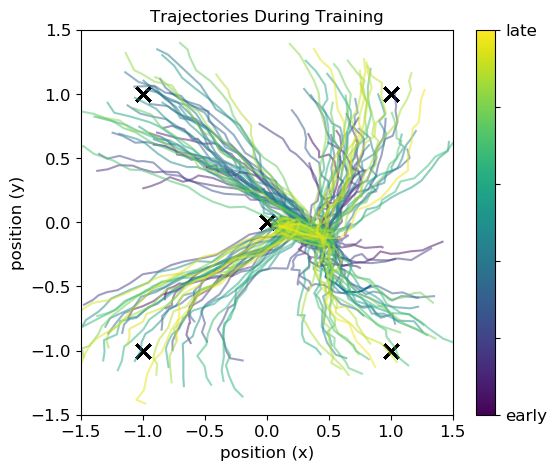

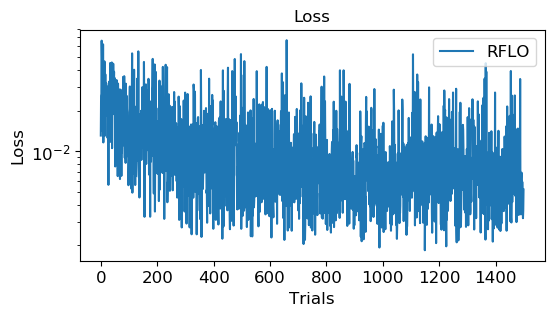

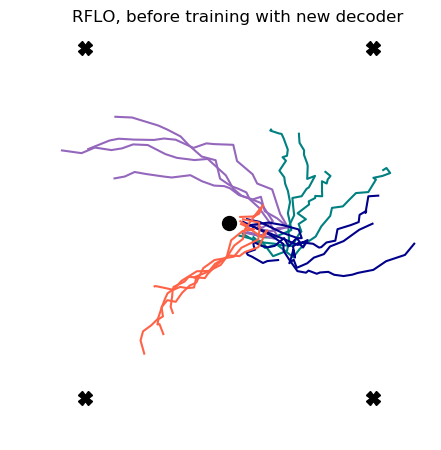

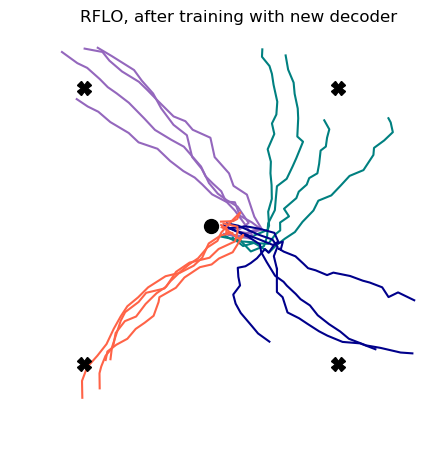

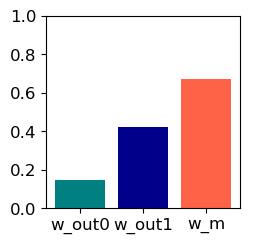

similarity DeltaC1 & DeltaC1_pred_w_out: 0.493
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.704
similarity DeltaC1 & DeltaC1_pred_w_m: 0.943


>> CTRL DeltaC1 & CTRL_h1_pre: 0.529
>> CTRL DeltaC1 & CTRL_h1_post: 0.860
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.402
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.519
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.648




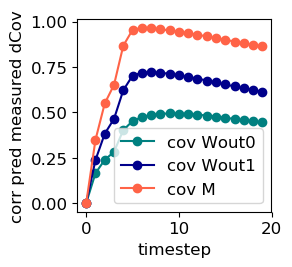

0it [00:00, ?it/s]

M norm: 0.67	 M angle: 0.89, 579 iterations
w_out1 norm: 0.76	 w_out vs. w_out1 angle: 0.89
w_m norm: 0.67	 w_out1 vs. w_m angle: 0.89
w_m norm: 1.08	 w_out vs. w_m angle: 0.77

500it [00:00, 685.19it/s]
1500it [00:04, 343.04it/s]
500it [00:00, 793.26it/s]


AR early fit 0.963, late fit 0.970


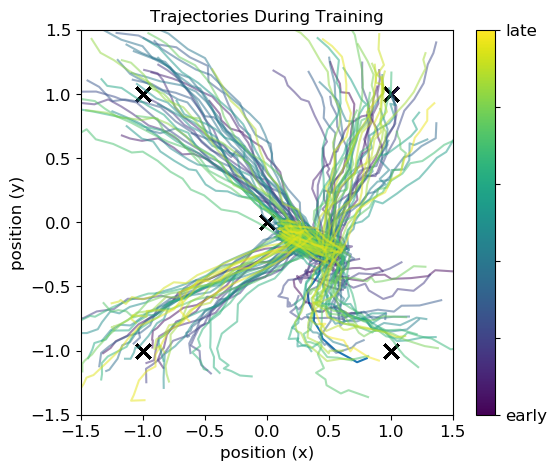

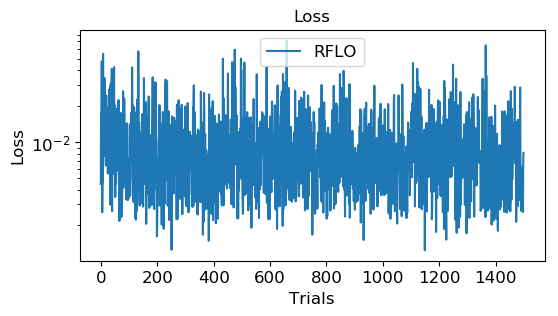

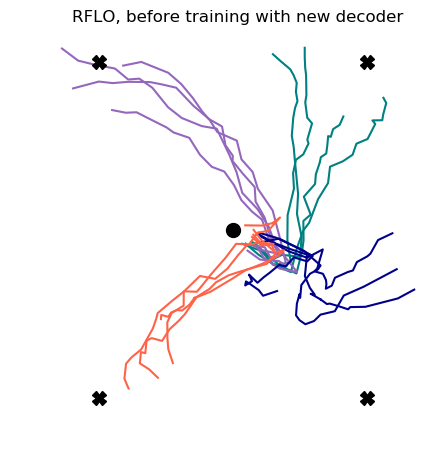

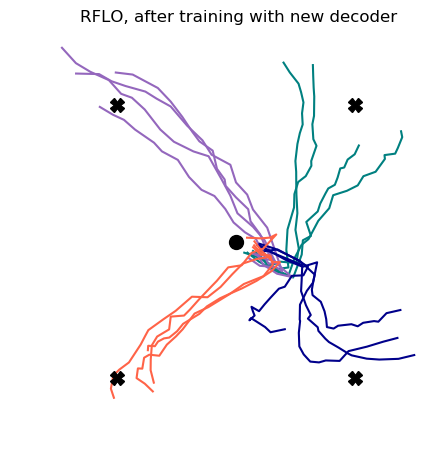

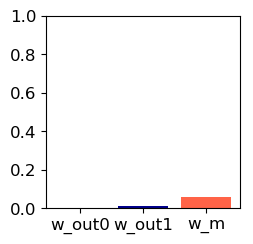

similarity DeltaC1 & DeltaC1_pred_w_out: 0.739
similarity DeltaC1 & DeltaC1_pred_w_out1: 0.778
similarity DeltaC1 & DeltaC1_pred_w_m: 0.845


>> CTRL DeltaC1 & CTRL_h1_pre: 0.805
>> CTRL DeltaC1 & CTRL_h1_post: 0.895
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.577
>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: 0.564
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.573




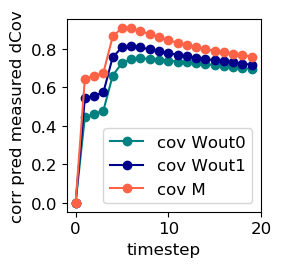

In [81]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,12]#,54,72,81]
overlaps = [0.25,0.5,0.75,0.9]
n_changes = [75,50,50,30]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
        """ Calculate Covariance """
        """ Activity During """
        covariance1 = np.zeros(task1.trial_duration)
        covariance2 = np.zeros(task1.trial_duration)
        covariance3 = np.zeros(task1.trial_duration)
        
        for t_ind in range(1,task1.trial_duration):
            """ Covariance Before """
            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

            C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

            """ Covariance After """
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point
            
            """ Change in Covariance (Measured)"""
            DeltaC1 = C1_post - C1_pre

            h1_train = sim1_train.session_probes['h']
            err1_train = sim1_train.session_probes['err']

            dW1_w_out = flow_field_predicted(net0.w_out,err1_train,h1_train)
            dW1_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_out1 = flow_field_predicted(net1.w_out,err1_train,h1_train)
            dW1_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
            dW1_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

            h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
            h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

            C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_out1 = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out1@(h1_pre[:,t_ind-1,:].T))
            C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_pre[:,t_ind-1,:].T))
            
            """ Change in Covariance (Predicted) """
            DeltaC1_pred_w_out = C1_pred_w_out - C1_pre
            DeltaC1_pred_w_out1 = C1_pred_w_out1 - C1_pre
            DeltaC1_pred_w_m = C1_pred_w_m - C1_pre

            covariance1[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]
            covariance2[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]
            covariance3[t_ind] = np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]
            


            if t_ind == 10:
                print('similarity DeltaC1 & DeltaC1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_out1.ravel())[0,1]))
                print('similarity DeltaC1 & DeltaC1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),DeltaC1_pred_w_m.ravel())[0,1]))
                print('\n')

            CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
            CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
            CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_out1_h1_post = np.cov(dW1_w_out1@(h1_post[:,t_ind,:].T))
            CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

            if t_ind == 10:
                print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_out1_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out1_h1_post.ravel())[0,1]))
                print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

                print('\n')
                
        covariance1_list.append(covariance1)
        covariance2_list.append(covariance2)
        covariance3_list.append(covariance3)
        
        fig,ax = plt.subplots(1,1)
        plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
        plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
        plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
        plt.legend()
        plt.xlabel('timestep')
        plt.ylabel('corr pred measured dCov')
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)
    stats['covariance1'].append(covariance1_list)
    stats['covariance2'].append(covariance2_list)
    stats['covariance3'].append(covariance3_list)


In [82]:
""" save dict with unique name """
stats_rflo_m = stats

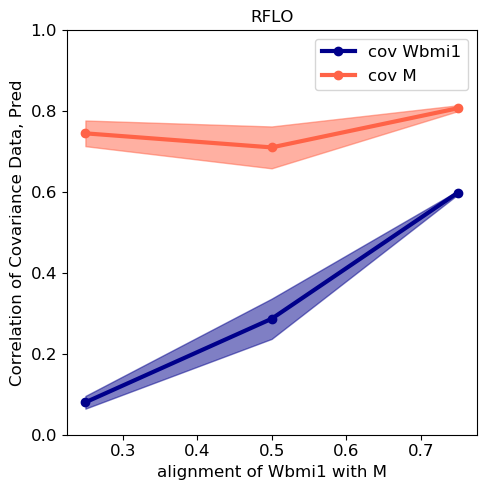

In [86]:
save = False
paper = False

fig,ax = plt.subplots(1,1,figsize=(5,5))


mn1 = np.mean(np.sum(np.asarray(stats_rflo_m['covariance1']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time
mn2 = np.mean(np.sum(np.asarray(stats_rflo_m['covariance2']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time
mn3 = np.mean(np.sum(np.asarray(stats_rflo_m['covariance3']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time

std1 = np.std(np.sum(np.asarray(stats_rflo_m['covariance1']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time
std2 = np.std(np.sum(np.asarray(stats_rflo_m['covariance2']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time
std3 = np.std(np.sum(np.asarray(stats_rflo_m['covariance3']),axis=2)/task1.trial_duration,axis=0)[:-1] # seed by m by time

#plt.plot(overlaps,mn1,'o-',linewidth=3,label='cov Wbmi0',color='teal')
plt.plot(overlaps[:-1],mn2,'o-',linewidth=3,label='cov Wbmi1',color='darkblue')
plt.fill_between(overlaps[:-1],mn2-std2,mn2+std2,alpha=0.5,color='darkblue')

plt.plot(overlaps[:-1],mn3,'o-',linewidth=3,label='cov M',color='tomato')
plt.fill_between(overlaps[:-1],mn3-std3,mn3+std3,alpha=0.5,color='tomato')
plt.ylim([0,1])
plt.legend()
plt.title('RFLO')
plt.xlabel('alignment of Wbmi1 with M')
plt.ylabel('Correlation of Covariance Data, Pred')

plt.tight_layout()
plt.show()

if save:

    fig.savefig('rflo-cov-change-alignment.pdf')

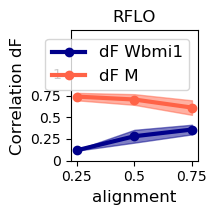

In [99]:
""" Same plot using flow field """
paper = True
save = True


fig,ax = plt.subplots(1,1,figsize=(5,5))

mn1 = np.mean(np.asarray(stats_rflo_m['corr1']),axis=0)[:-1]
std1 = np.std(np.asarray(stats_rflo_m['corr1']),axis=0)[:-1]

mn2 = np.mean(np.asarray(stats_rflo_m['corr2']),axis=0)[:-1]
std2 = np.std(np.asarray(stats_rflo_m['corr2']),axis=0)[:-1]

mn3 = np.mean(np.asarray(stats_rflo_m['corr3']),axis=0)[:-1]
std3 = np.std(np.asarray(stats_rflo_m['corr3']),axis=0)[:-1]

plt.plot(overlaps[:-1],mn2,'o-',linewidth=3,label='dF Wbmi1',color='darkblue')
plt.fill_between(overlaps[:-1],mn2-std2,mn2+std2,alpha=0.5,color='darkblue')

plt.plot(overlaps[:-1],mn3,'o-',linewidth=3,label='dF M',color='tomato')
plt.fill_between(overlaps[:-1],mn3-std3,mn3+std3,alpha=0.5,color='tomato')
plt.ylim([-0.2,1])
plt.legend()
plt.title('RFLO')
plt.xlabel('alignment')
plt.ylabel('Correlation dF')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.25,0.5,0.75,1],ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[0,1.5],figsize=(2.25,2.25))

plt.show()

if save:
    fig.savefig(folder+'rflo-dF-change-m.pdf')


# Part 4 - REINFORCE ACROSS Wbmi0


Here, I pretrain a single network with decoder `W_bmi0` and then change the decoder to `W_bmi1` and train again with REINFORCE. Since REINFORCE does not rely on `W_m`, the only matrices we care about are `W_bmi0` and `W_bmi1`. Here I vary the alignment between these two decoders and then apply the two general metrics to the simulation results.

Note: Unfortunately this simulation takes a little too long, and might not be worth doing frequently. I've saved the results in a dict called `stats_reinforce_wout.pickle`

```
""" Average over multiple seeds """
seeds = [0,1,12,54,72,81]
overlaps = [0.5,0.6,0.7,0.8,0.9,1]
n_changes = [50,50,50,40,30,1]
```

20it [00:00, 198.38it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fa57004fdc8>


2500it [00:06, 409.93it/s]
0it [00:00, ?it/s]


~~~~ OVERLAP 0.1, SEED 1


M norm: 1.04	 M angle: 0.11, 12 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.10
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.11
w_m norm: 1.77	 w_out vs. w_m angle: 0.12

1000it [00:01, 926.47it/s]
15000it [00:35, 422.74it/s]
1000it [00:01, 865.07it/s]


AR early fit 0.964, late fit 0.973


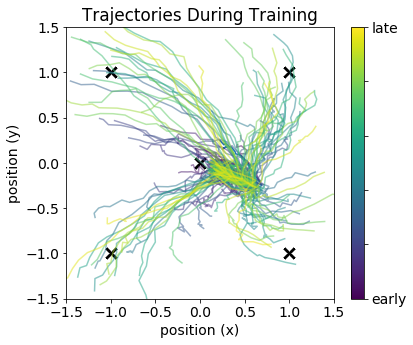

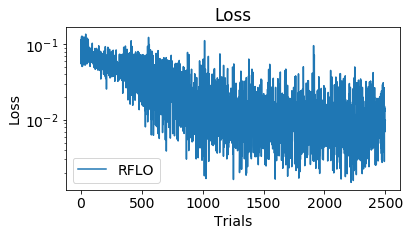

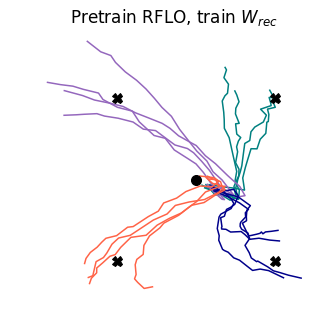

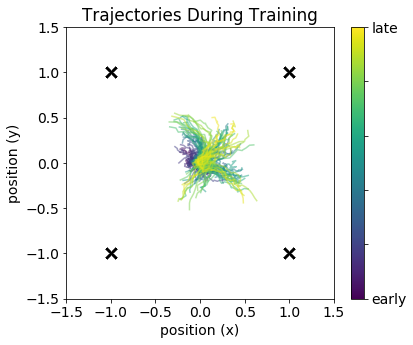

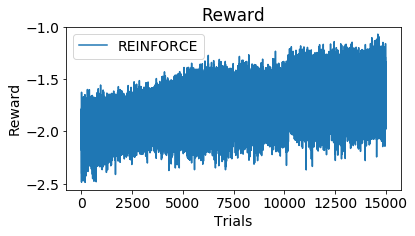

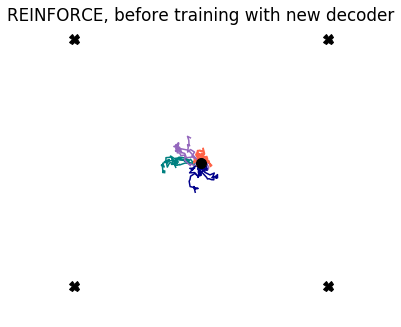

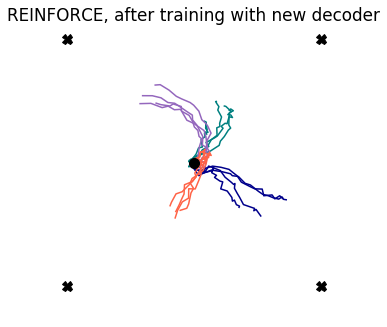

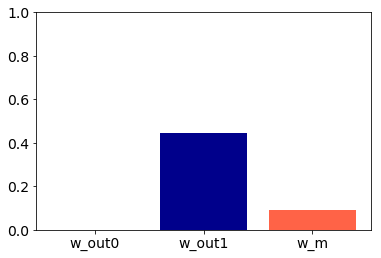

In [ ]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [1]#,12,54,72,81]
overlaps = [0.1] #,0.5,1]
n_changes = [2*50] #,50,1]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        print('\n~~~~ OVERLAP {}, SEED {}'.format(overlap,seed))
        print('\n')
        
        """ choose new decoder w_out1 """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ choose new internal model w_m """
        w_m = choose_aligned_matrix(w_out1.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=15000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
        
        """ Calculate Covariance """
        """ Activity During """
        covariance1 = np.zeros(task1.trial_duration)
        covariance2 = np.zeros(task1.trial_duration)
        covariance3 = np.zeros(task1.trial_duration)
        
        for t_ind in range(1,task1.trial_duration):
            """ Covariance Before """
            h2_pre = np.asarray(sim2_pre.session_probes['h']).squeeze()

            C2_pre = np.cov(h2_pre[:,t_ind,:].T) # neurons x trials at a single time point

            """ Covariance After """
            h2_post = np.asarray(sim2_post.session_probes['h']).squeeze()

            C2_post = np.cov(h2_post[:,t_ind,:].T) # neurons x trials at a single time point

            DeltaC2 = C2_post - C2_pre

            h2_train = sim2_train.session_probes['h']
            err2_train = sim2_train.session_probes['err']

            dW2_w_out = flow_field_predicted(net0.w_out,err2_train,h2_train)
            dW2_w_out *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW2_w_out1 = flow_field_predicted(w_out1,err2_train,h2_train)
            dW2_w_out1 *= 0.001 #dW1_w_out/LA.norm(dW1_w_out)
            dW2_w_m = flow_field_predicted(w_m,err2_train,h2_train) # w_m defined above
            dW2_w_m *= 0.001 #dW1_w_m/LA.norm(dW1_w_m)

            h2_pre = np.asarray(sim2_pre.session_probes['h']).squeeze()
            h2_post = np.asarray(sim2_post.session_probes['h']).squeeze()

            C2_pred_w_out = np.cov(h2_pre[:,t_ind,:].T + dW2_w_out@(h2_post[:,t_ind,:].T))
            C2_pred_w_out1 = np.cov(h2_pre[:,t_ind,:].T + dW2_w_out1@(h2_post[:,t_ind,:].T))
            C2_pred_w_m = np.cov(h2_pre[:,t_ind,:].T + dW2_w_m@(h2_post[:,t_ind,:].T))
            
            dC2_pred_w_out = C2_pred_w_out - C2_pre
            dC2_pred_w_out1 = C2_pred_w_out1 - C2_pre
            dC2_pred_w_m = C2_pred_w_m - C2_pre

            covariance1[t_ind] = np.corrcoef(DeltaC2.ravel(),dC2_pred_w_out.ravel())[0,1]
            covariance2[t_ind] = np.corrcoef(DeltaC2.ravel(),dC2_pred_w_out1.ravel())[0,1]
            covariance3[t_ind] = np.corrcoef(DeltaC2.ravel(),dC2_pred_w_m.ravel())[0,1]
            


            if t_ind == 10:
                print('similarity DeltaC2 & C2_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),dC2_pred_w_out.ravel())[0,1]))
                print('similarity DeltaC2 & C2_pred_w_out1: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),dC2_pred_w_out1.ravel())[0,1]))
                print('similarity DeltaC2 & C2_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),dC2_pred_w_m.ravel())[0,1]))
                print('\n')

            CTRL_h2_pre = np.cov(h2_pre[:,t_ind,:].T)
            CTRL_h2_post = np.cov(h2_post[:,t_ind,:].T)
            CTRL_dW2_w_out_h2_post = np.cov(dW2_w_out@(h2_post[:,t_ind,:].T))
            CTRL_dW2_w_out1_h2_post = np.cov(dW2_w_out1@(h2_post[:,t_ind,:].T))
            CTRL_dW2_w_m_h2_post = np.cov(dW2_w_m@(h2_post[:,t_ind,:].T))

            if t_ind == 10:
                print('>> CTRL DeltaC2 & CTRL_h2_pre: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_h2_pre.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_out_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_out_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_out1_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_out1_h2_post.ravel())[0,1]))
                print('>> CTRL DeltaC2 & CTRL_dW2_w_m_h2_post: {:.3f}'.format(np.corrcoef(DeltaC2.ravel(),CTRL_dW2_w_m_h2_post.ravel())[0,1]))

                print('\n')
                
        covariance1_list.append(covariance1)
        covariance2_list.append(covariance2)
        covariance3_list.append(covariance3)
        
        fig,ax = plt.subplots(1,1)
        plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
        plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
        plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
        plt.legend()
        plt.xlabel('timestep')
        plt.ylabel('corr pred measured dCov')
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)
    
    stats['covariance1'].append(covariance1_list)
    stats['covariance2'].append(covariance2_list)
    stats['covariance3'].append(covariance3_list)


In [ ]:
stats_reinforce_wout = stats


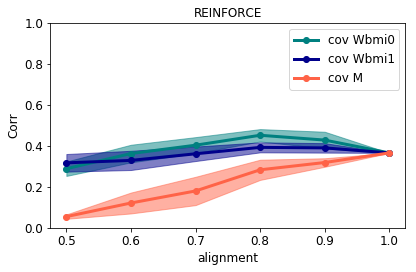

In [187]:
save = False
paper = False
if paper:
    fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
else:
    fig,ax = plt.subplots(1,1)
lw,fs = paper_format()
fs = 12

mn1 = np.mean(np.sum(np.asarray(stats_reinforce_wout['covariance1']),axis=2)/task1.trial_duration,axis=0) # seed by m by time
mn2 = np.mean(np.sum(np.asarray(stats_reinforce_wout['covariance2']),axis=2)/task1.trial_duration,axis=0) # seed by m by time
mn3 = np.mean(np.sum(np.asarray(stats_reinforce_wout['covariance3']),axis=2)/task1.trial_duration,axis=0) # seed by m by time

std1 = np.std(np.sum(np.asarray(stats_reinforce_wout['covariance1']),axis=2)/task1.trial_duration,axis=0) # seed by m by time
std2 = np.std(np.sum(np.asarray(stats_reinforce_wout['covariance2']),axis=2)/task1.trial_duration,axis=0) # seed by m by time
std3 = np.std(np.sum(np.asarray(stats_reinforce_wout['covariance3']),axis=2)/task1.trial_duration,axis=0) # seed by m by time

plt.plot(overlaps[:],mn1[:],'o-',linewidth=3,label='cov Wbmi0',color='teal')
plt.fill_between(overlaps[:],mn1[:]-std1[:],mn1[:]+std1[:],alpha=0.5,color='teal')

plt.plot(overlaps[:],mn2[:],'o-',linewidth=3,label='cov Wbmi1',color='darkblue')
plt.fill_between(overlaps[:],mn2[:]-std2[:],mn2[:]+std2[:],alpha=0.5,color='darkblue')

plt.plot(overlaps[:],mn3[:],'o-',linewidth=3,label='cov M',color='tomato')
plt.fill_between(overlaps[:],mn3[:]-std3[:],mn3[:]+std3[:],alpha=0.5,color='tomato')
plt.ylim([0,1])
plt.legend(fontsize=fs)
plt.title('REINFORCE',fontsize=fs)
plt.xlabel('alignment',fontsize=fs)
plt.ylabel('Corr',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

if paper:
    from matplotlib.ticker import FixedLocator,FixedFormatter
    ax.xaxis.set_major_locator(FixedLocator(overlaps[:]))
    ax.xaxis.set_major_formatter(FixedFormatter(overlaps[:]))


plt.tight_layout()
plt.show()



if save:

    fig.savefig('reinforce-cov-change-alignment.pdf')

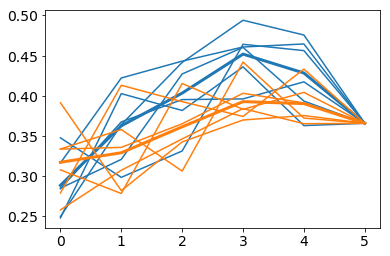

In [198]:
a = np.sum(np.asarray(stats_reinforce_wout['covariance1']),axis=2)/task1.trial_duration
plt.plot(a.T,color='C0')
plt.plot(np.mean(a.T,axis=1),linewidth=3,color='C0')
b = np.sum(np.asarray(stats_reinforce_wout['covariance2']),axis=2)/task1.trial_duration
plt.plot(b.T,color='C1')
plt.plot(np.mean(b.T,axis=1),linewidth=3,color='C1')

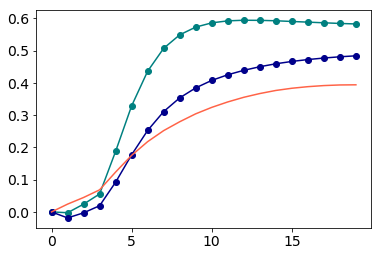

In [204]:
""" checking something """
plt.plot(np.asarray(stats_reinforce_wout['covariance1'])[0,2,:].T,'o-',label='cov Wout0',color='teal')
plt.plot(np.asarray(stats_reinforce_wout['covariance2'])[0,2,:].T,'o-',label='cov Wout1',color='darkblue')
plt.plot(np.asarray(stats_reinforce_wout['covariance3'])[0,2,:].T,'-',label='cov W_M',color='tomato')


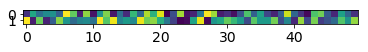

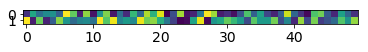

In [178]:
plt.imshow(net0.w_out)
plt.show()
plt.imshow(net2.w_out)

In [172]:
np.asarray(stats_reinforce_wout['corr1']).shape

(1, 2)

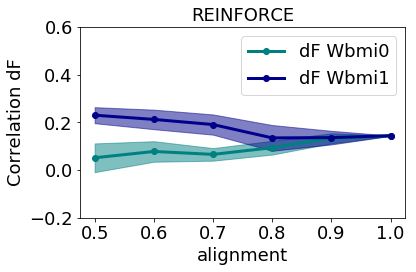

In [218]:
""" Same plot using flow field """

save = False
paper = False
if paper:
    fig,ax = plt.subplots(1,1,figsize=(2.5,2.5))
    lw = 1
    fs = 12
else:
    fig,ax = plt.subplots(1,1)
    lw = 3
    fs = 18





mn1 = np.mean(np.asarray(stats_reinforce_wout['corr1']),axis=0)
std1 = np.std(np.asarray(stats_reinforce_wout['corr1']),axis=0)

mn2 = np.mean(np.asarray(stats_reinforce_wout['corr2']),axis=0)
std2 = np.std(np.asarray(stats_reinforce_wout['corr2']),axis=0)

mn3 = np.mean(np.asarray(stats_reinforce_wout['corr3']),axis=0)
std3 = np.std(np.asarray(stats_reinforce_wout['corr3']),axis=0)

plt.plot(overlaps[:],mn1,'o-',linewidth=lw,label='dF Wbmi0',color='teal')
plt.fill_between(overlaps[:],mn1-std1,mn1+std1,alpha=0.5,color='teal')

plt.plot(overlaps[:],mn2,'o-',linewidth=lw,label='dF Wbmi1',color='darkblue')
plt.fill_between(overlaps[:],mn2-std2,mn2+std2,alpha=0.5,color='darkblue')

# plt.plot(overlaps[:],mn3,'o-',linewidth=3,label='dF M',color='tomato')
# plt.fill_between(overlaps[:],mn3-std3,mn3+std3,alpha=0.5,color='tomato')

plt.legend(fontsize=fs)
plt.title('REINFORCE',fontsize=fs)
plt.xlabel('alignment',fontsize=fs)
plt.ylabel('Correlation dF',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

if paper:
    plt.ylim([-0.2,0.6])
    ylabels = [0,0.2,0.4,0.6]
    from matplotlib.ticker import FixedLocator,FixedFormatter
    ax.xaxis.set_major_locator(FixedLocator(overlaps[:]))
    ax.xaxis.set_major_formatter(FixedFormatter(overlaps[:]))
    ax.yaxis.set_major_locator(FixedLocator(ylabels))
    ax.yaxis.set_major_formatter(FixedFormatter(ylabels))
    
else:
    plt.ylim([-0.2,0.6])


plt.tight_layout()
plt.show()


if save:

    fig.savefig('reinforce-dF-change-alignment.pdf')